2조 : 박지연, 김정현, 윤재현, 강현준, 이유성(팀장)

## Goal
- 모델의 목적
    - 프로슈머의 에너지 사용량 예측(https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers)
    - energy imbalance costs 문제 해결

데이터를 이용해 프로슈머의 에너지 생산 및 소비량을 예측해 energy imbalance costs로 인한 재정적인 문제를 해결

Target : 소비량 및 생산량
- is_consumption가 0이면 생산 1이면 소비

## Why
- 명확한 Insight 제공
    - 예측할 수 있는 라벨이 명확함
- 적은 결측치
    - Target데이터에만 결측치가 있는 것으로 예상
- external data간의 매핑이 가능한 key column이 있음

## How 
- 사용할 데이터 셋
    - train.csv, gas_prices.csv, client.csv, electricity_prices.csv, forecast_weather.csv, historical_weather.csv
- 자기회귀모델, 오차회귀모델, Transformer, MLP, 순환신경망
- MSE, MAPE, MAE, R2


## 데이터 설명
- train.csv
    - county
    - is_business - 프로슈머가 사업인지 아닌지에 대한 여부
    - product_type - 계약 유형
    - target - 해당 시간 동안의 생산 또는 소비량
    - is_consumption - 이 행의 목표가 소비인지 생산인지 아닌지의 여부
    - datetime - EET (UTC+2) / EEST (UTC+3)
    - data_block_id
    - row_id
    - prediction_unit_id
- gas_prices.csv
    - origin_date
    - forecast_date
    - [lowest/highest]_price_per_mwh - 해당 날짜의 최저가/최고가
    - data_block_id
- client.csv
    - product_type
    - county
    - eic_count - 총 소비 포인트 수(EIC - 유럽 식별자 코드)
    - installed_capacity -태양광 태양 전지판 용량(킬로와트)
    - is_business
    - date
    - data_block_id
- electricity_prices.csv
    - 전기 사용량 데이터
- forecast_weather.csv
    - 예측 시간의 일기 예보. 유럽 중기 기상 예보 센터에서 제공. 
- historical_weather.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- key column: data_block_id (일 단위)

# train.csv

### 기본적인 정보 확인

In [2]:
df = pd.read_csv("../../../../estsoft/data/train.csv")

In [3]:
df.tail(200)

county  is_business  product_type   target  is_consumption  \
2018152       7            0             3    9.034               0   
2018153       7            0             3  265.007               1   
2018154       7            1             0    0.000               0   
2018155       7            1             0  369.222               1   
2018156       7            1             1    0.037               0   
...         ...          ...           ...      ...             ...   
2018347      15            1             0  197.233               1   
2018348      15            1             1    0.000               0   
2018349      15            1             1   28.404               1   
2018350      15            1             3    0.000               0   
2018351      15            1             3  196.240               1   

                    datetime  data_block_id   row_id  prediction_unit_id  
2018152  2023-05-31 22:00:00            637  2018152                  27  
2018153  2023-05-31 22:00:00            637  2018153                  27  
2018154  2023-05-31 22:00:00            637  2018154                  28  
2018155  2023-05-31 22:00:00            637  2018155                  28  
2018156  2023-05-31 22:00:00            637  2018156                  29  
...                      ...            ...      ...                 ...  
2018347  2023-05-31 23:00:00            637  2018347                  64  
2018348  2023-05-31 23:00:00            637  2018348                  59  
2018349  2023-05-31 23:00:00            637  2018349                  59  
2018350  2023-05-31 23:00:00            637  2018350                  60  
2018351  2023-05-31 23:00:00            637  2018351                  60  

[200 rows x 9 columns]

In [4]:
df.tail()

county  is_business  product_type   target  is_consumption  \
2018347      15            1             0  197.233               1   
2018348      15            1             1    0.000               0   
2018349      15            1             1   28.404               1   
2018350      15            1             3    0.000               0   
2018351      15            1             3  196.240               1   

                    datetime  data_block_id   row_id  prediction_unit_id  
2018347  2023-05-31 23:00:00            637  2018347                  64  
2018348  2023-05-31 23:00:00            637  2018348                  59  
2018349  2023-05-31 23:00:00            637  2018349                  59  
2018350  2023-05-31 23:00:00            637  2018350                  60  
2018351  2023-05-31 23:00:00            637  2018351                  60

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [7]:
df.describe()

county   is_business  product_type        target  is_consumption  \
count  2.018352e+06  2.018352e+06  2.018352e+06  2.017824e+06       2018352.0   
mean   7.297034e+00  5.368261e-01  1.898927e+00  2.748556e+02             0.5   
std    4.780990e+00  4.986421e-01  1.081766e+00  9.095024e+02             0.5   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             0.0   
25%    3.000000e+00  0.000000e+00  1.000000e+00  3.780000e-01             0.0   
50%    7.000000e+00  1.000000e+00  2.000000e+00  3.113300e+01             0.5   
75%    1.100000e+01  1.000000e+00  3.000000e+00  1.802062e+02             1.0   
max    1.500000e+01  1.000000e+00  3.000000e+00  1.548027e+04             1.0   

       data_block_id        row_id  prediction_unit_id  
count   2.018352e+06  2.018352e+06        2.018352e+06  
mean    3.218746e+02  1.009176e+06        3.304538e+01  
std     1.826343e+02  5.826482e+05        1.959059e+01  
min     0.000000e+00  0.000000e+00        0.000000e+00  
25%     1.660000e+02  5.045878e+05        1.600000e+01  
50%     3.230000e+02  1.009176e+06        3.300000e+01  
75%     4.790000e+02  1.513763e+06        5.000000e+01  
max     6.370000e+02  2.018351e+06        6.800000e+01

In [6]:
df.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [7]:
df_prod =df[df['is_consumption']==0]
df_prod.isnull().sum()

county                  0
is_business             0
product_type            0
target                264
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [8]:
df_cons = df[df['is_consumption']==1]
df_cons.isnull().sum()

county                  0
is_business             0
product_type            0
target                264
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [9]:
df_null = df[df.isnull().any(axis=1)]
df_null['datetime'].value_counts()

datetime
2022-10-30 03:00:00    136
2022-03-27 03:00:00    134
2023-03-26 03:00:00    132
2021-10-31 03:00:00    126
Name: count, dtype: int64

- 특정 날짜의 03시에만 null값이 있음

### 인덱스 변경

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [9]:
df.index = df['datetime']
df.index

DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 00:00:00',
               '2021-09-01 00:00:00', '2021-09-01 00:00:00',
               '2021-09-01 00:00:00', '2021-09-01 00:00:00',
               '2021-09-01 00:00:00', '2021-09-01 00:00:00',
               '2021-09-01 00:00:00', '2021-09-01 00:00:00',
               ...
               '2023-05-31 23:00:00', '2023-05-31 23:00:00',
               '2023-05-31 23:00:00', '2023-05-31 23:00:00',
               '2023-05-31 23:00:00', '2023-05-31 23:00:00',
               '2023-05-31 23:00:00', '2023-05-31 23:00:00',
               '2023-05-31 23:00:00', '2023-05-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=2018352, freq=None)

### categorical column의 데이터 분포 확인

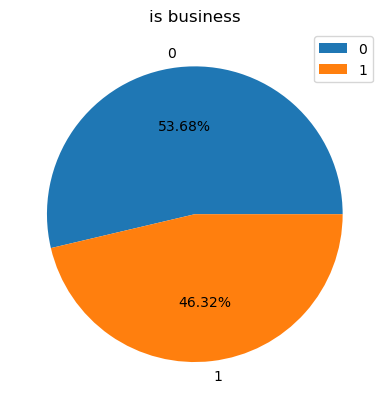

In [10]:
plt.pie(df['is_business'].value_counts(), labels=df['is_business'].unique(), autopct='%.2f%%')
plt.title('is business')
plt.legend()

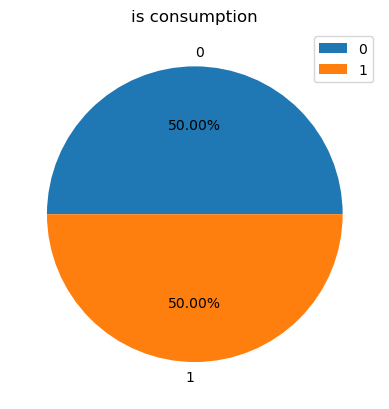

In [11]:
plt.pie(df['is_consumption'].value_counts(), labels=df['is_consumption'].unique(), autopct='%.2f%%')
plt.title('is consumption')
plt.legend()

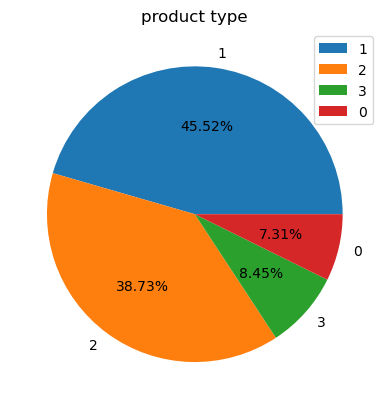

In [12]:
plt.pie(df['product_type'].value_counts(), labels=df['product_type'].unique(), autopct='%.2f%%')
plt.title('product type')
plt.legend()

Text(0.5, 1.0, 'county')

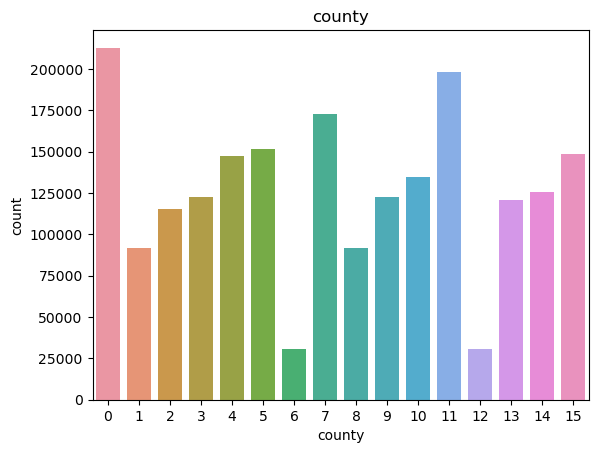

In [13]:
sns.countplot(x='county', data=df)
plt.title('county')

- 데이터 불균형
    - production_type 
    - county

### 에너지 생산량

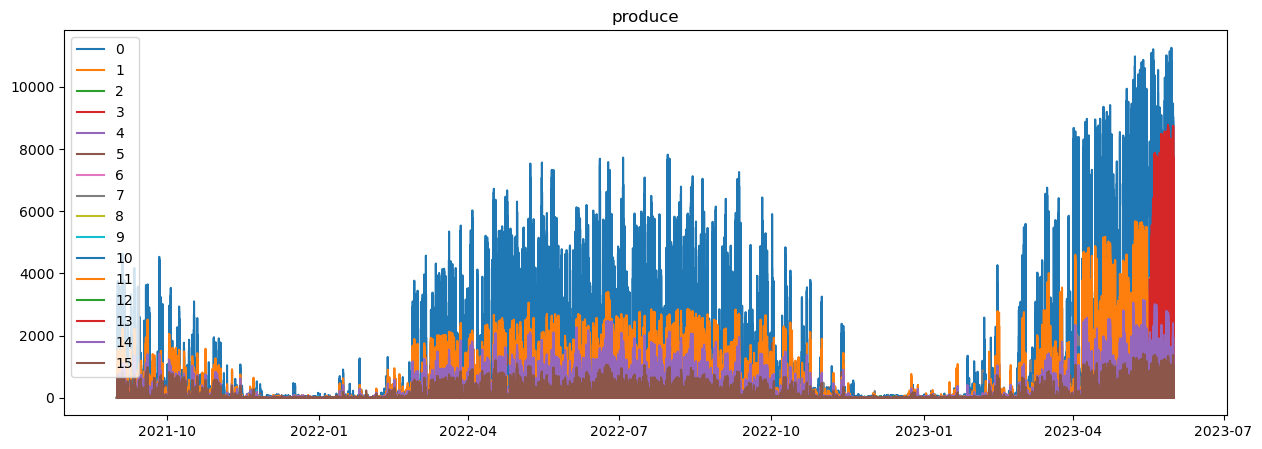

In [14]:
# county별 생산량
df_produce = df[df['is_consumption']==0]
plt.figure(figsize=(15,5))
for i in range(len(df['county'].unique())):
    plt.plot(df_produce[df_produce['county']==i]['target'], label=i)
plt.title('produce')
plt.legend()

/tmp/ipykernel_829785/3455012535.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,5))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1500x500 with 0 Axes>

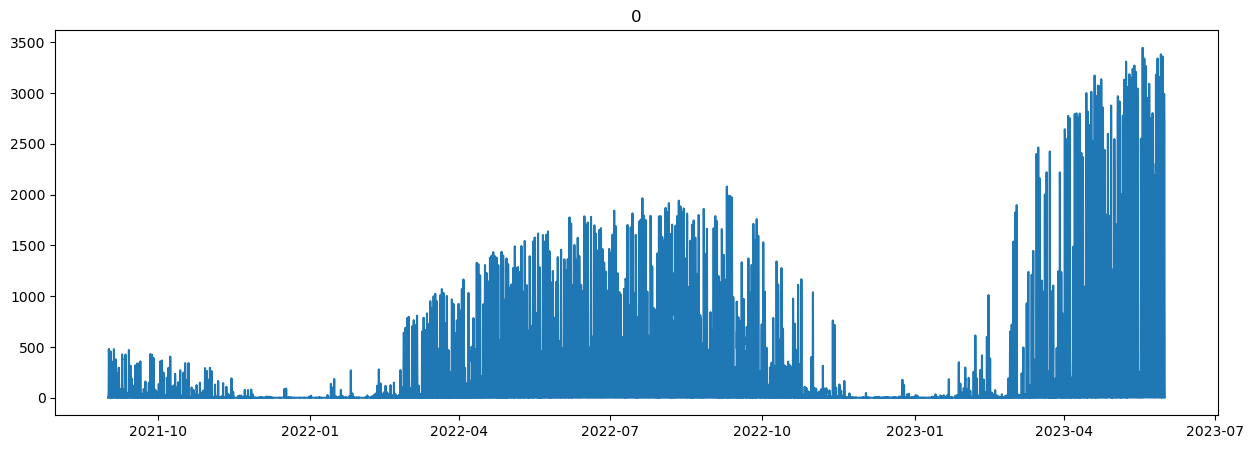

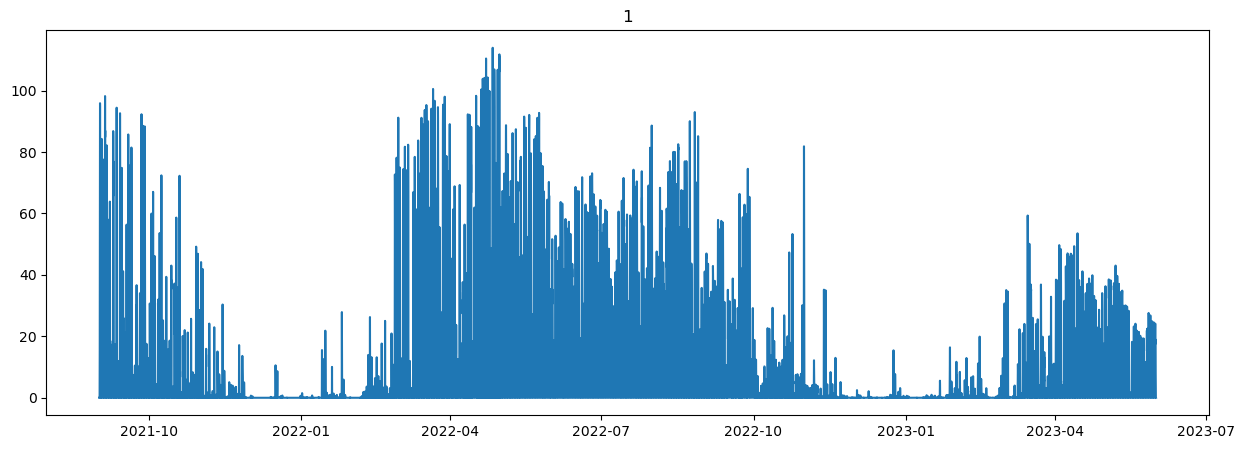

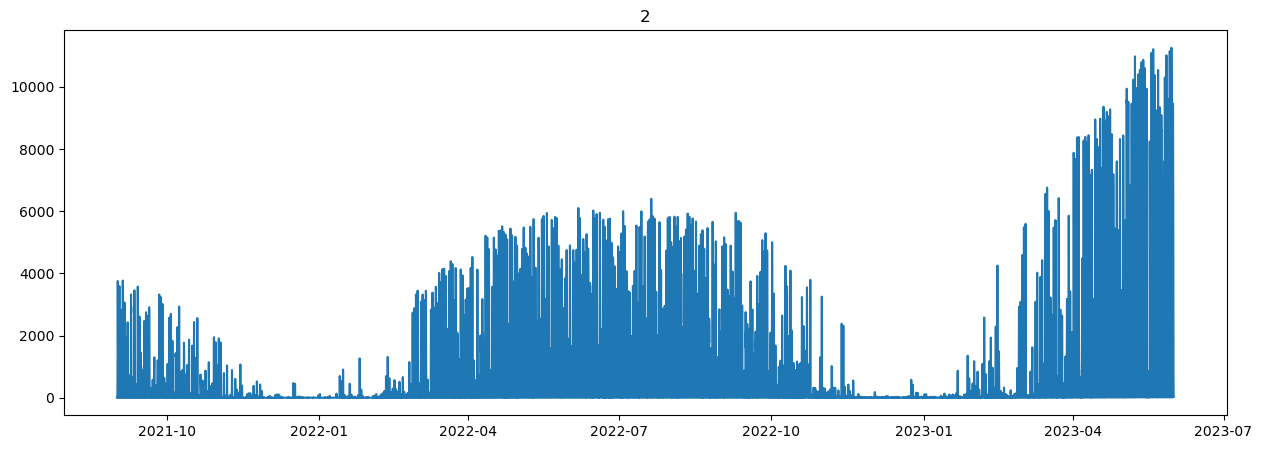

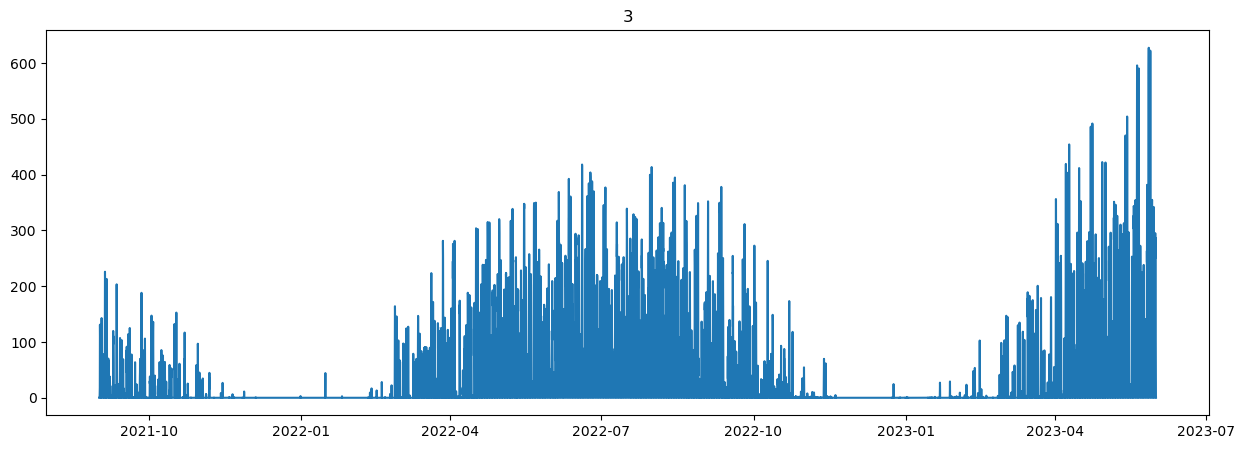

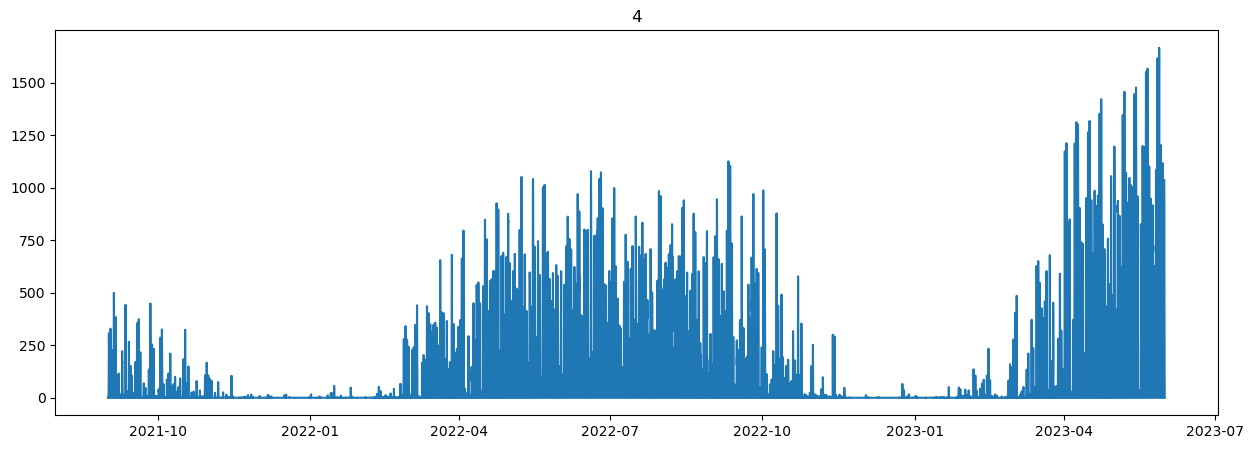

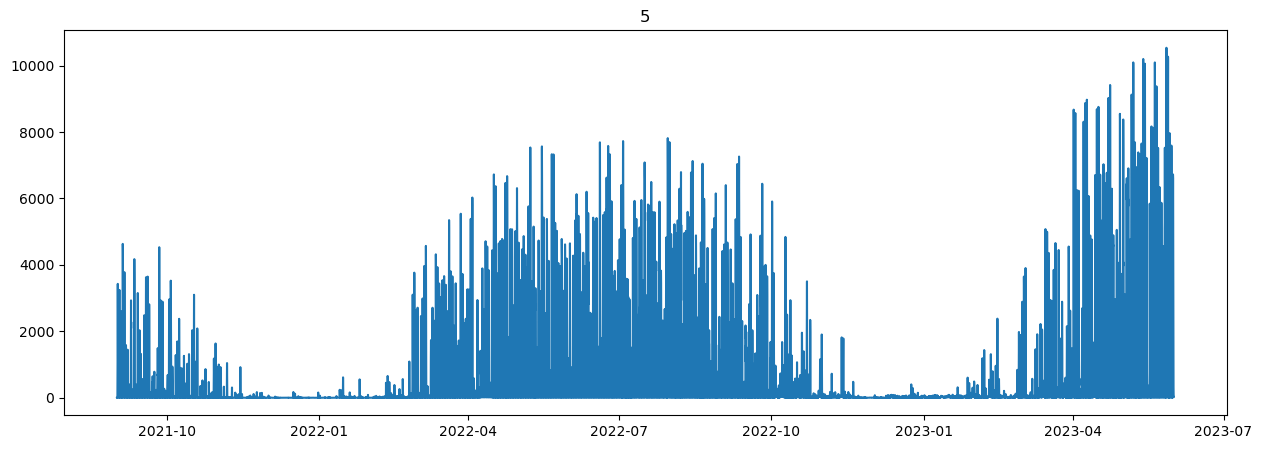

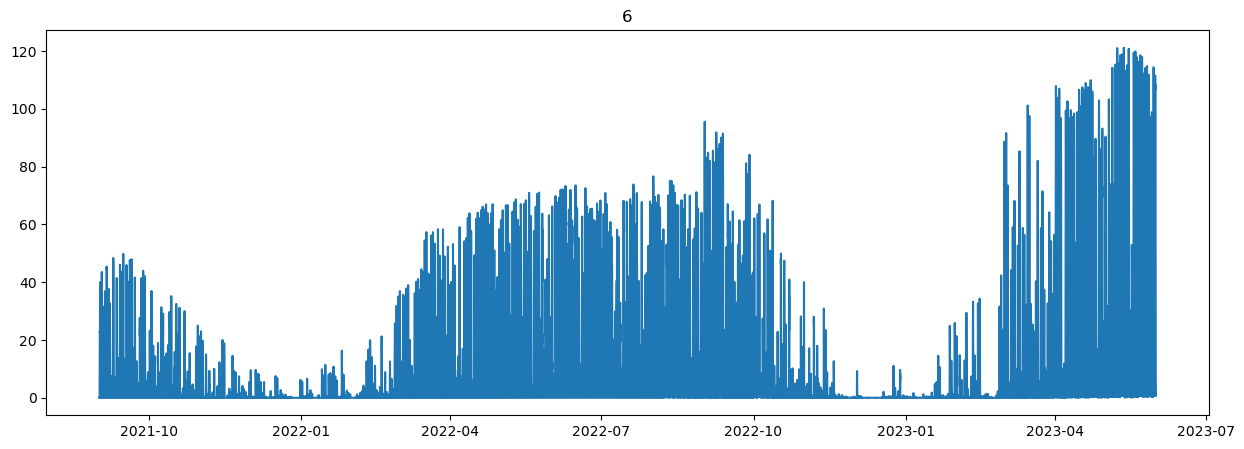

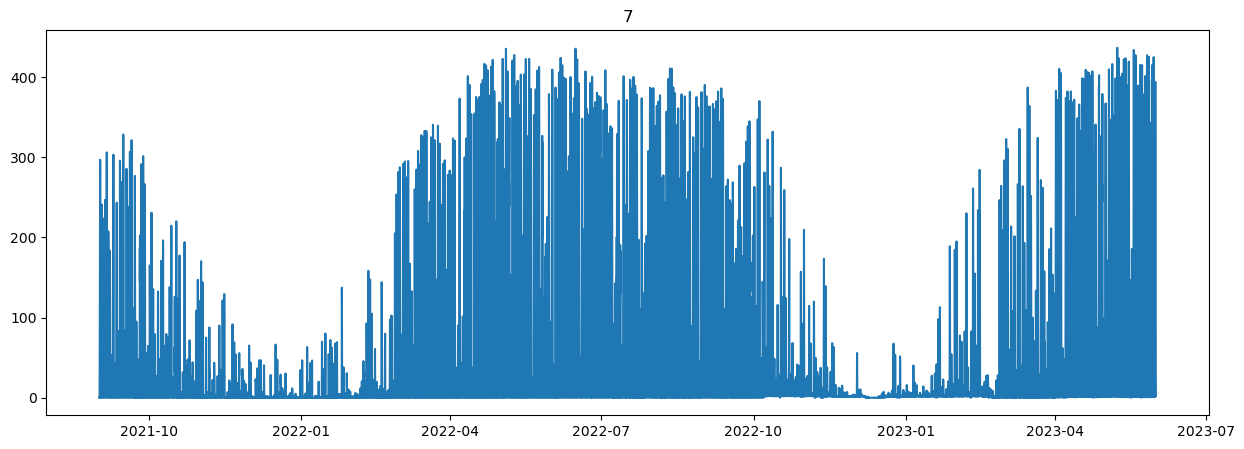

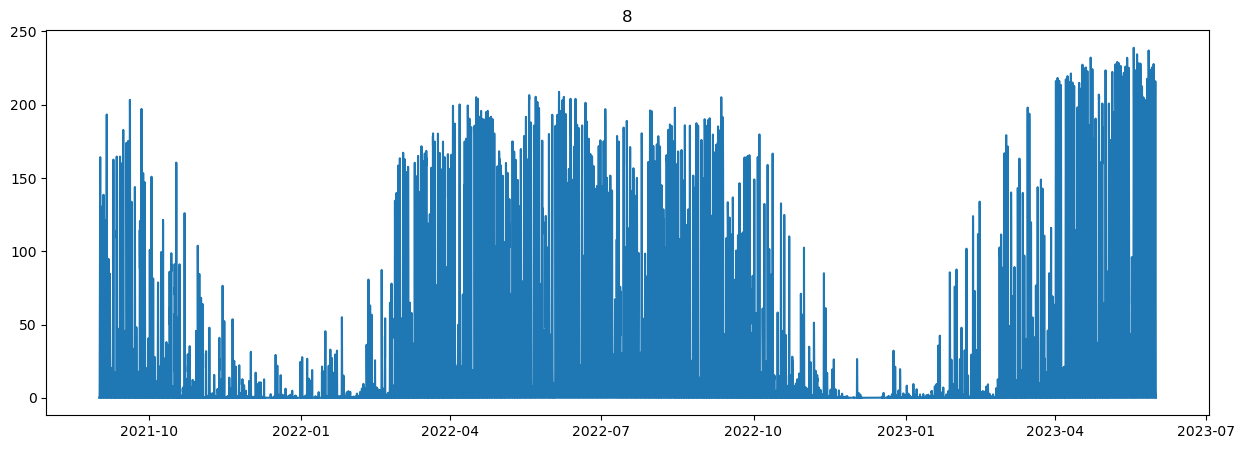

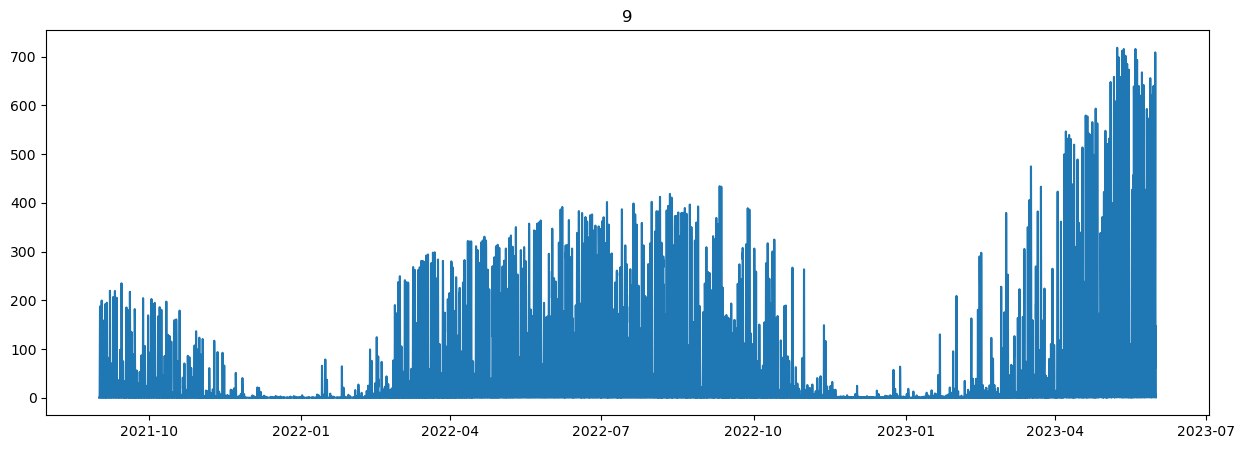

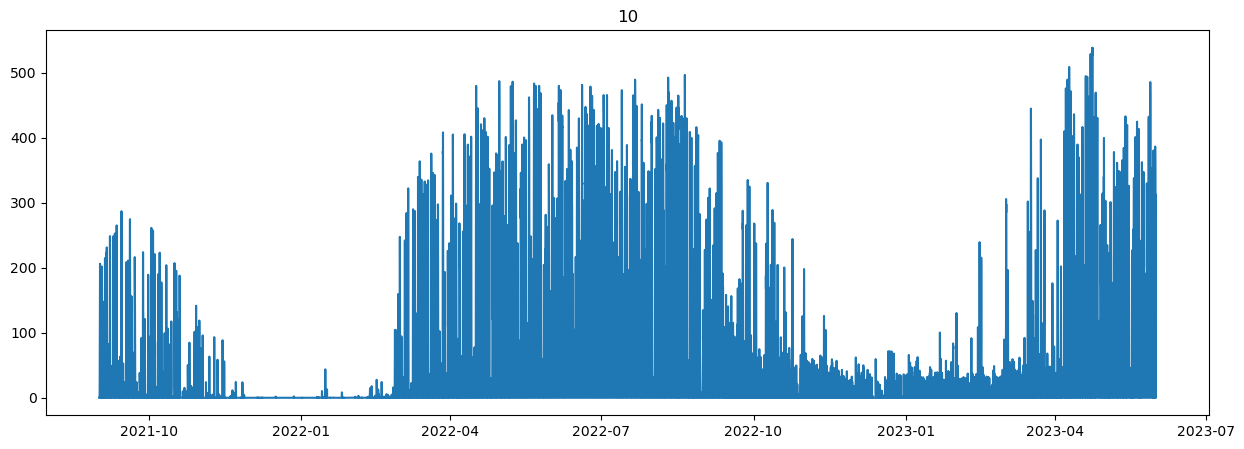

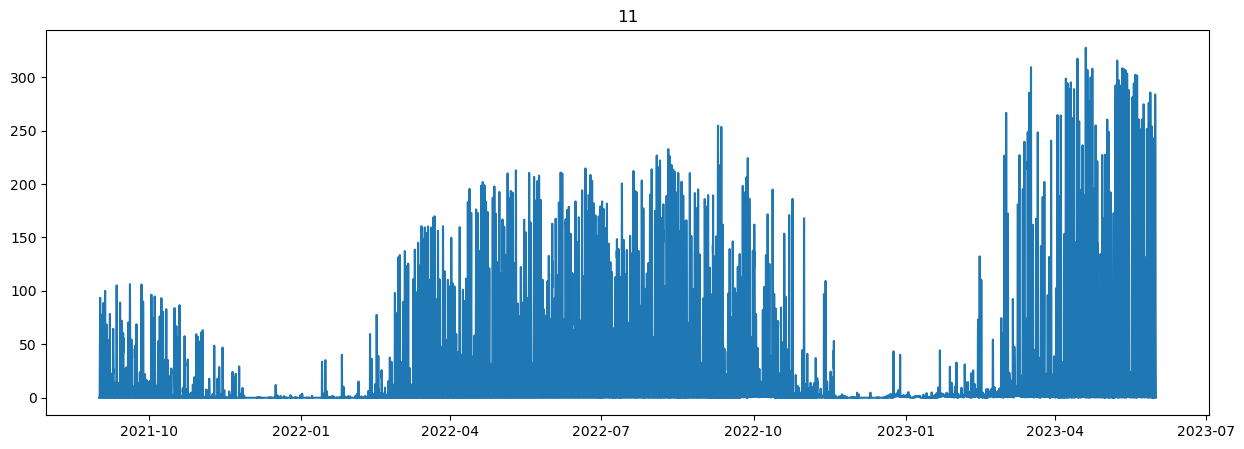

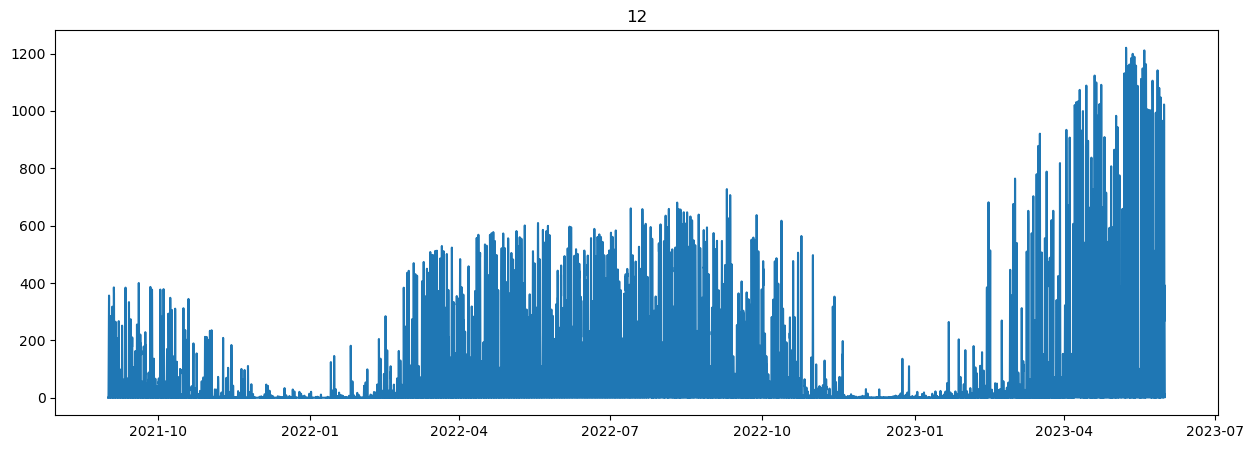

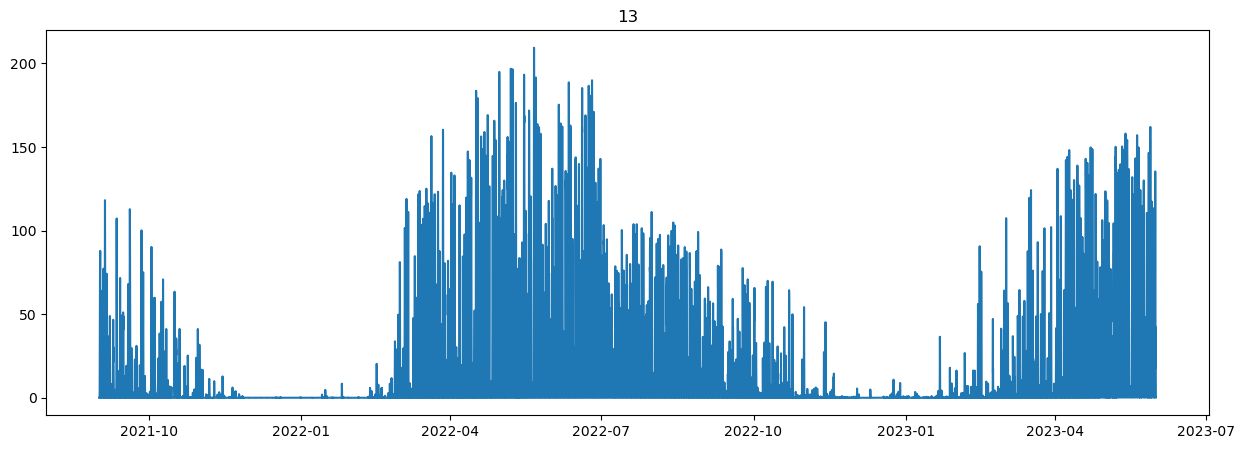

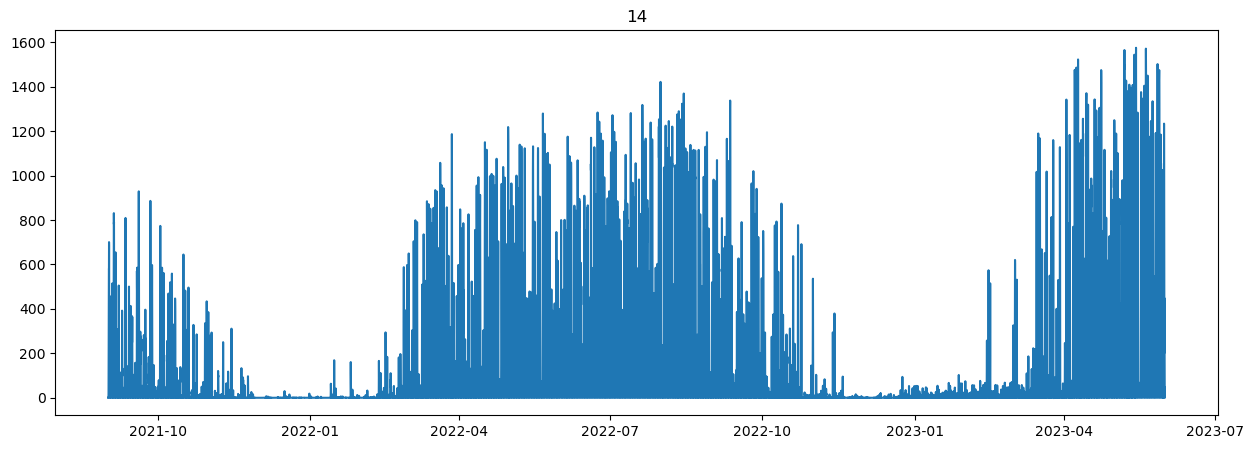

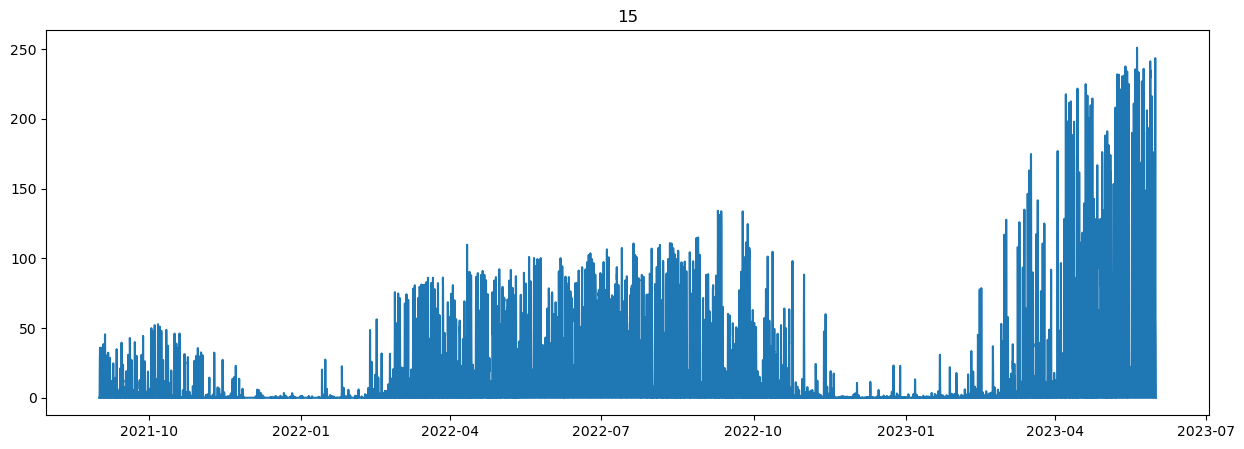

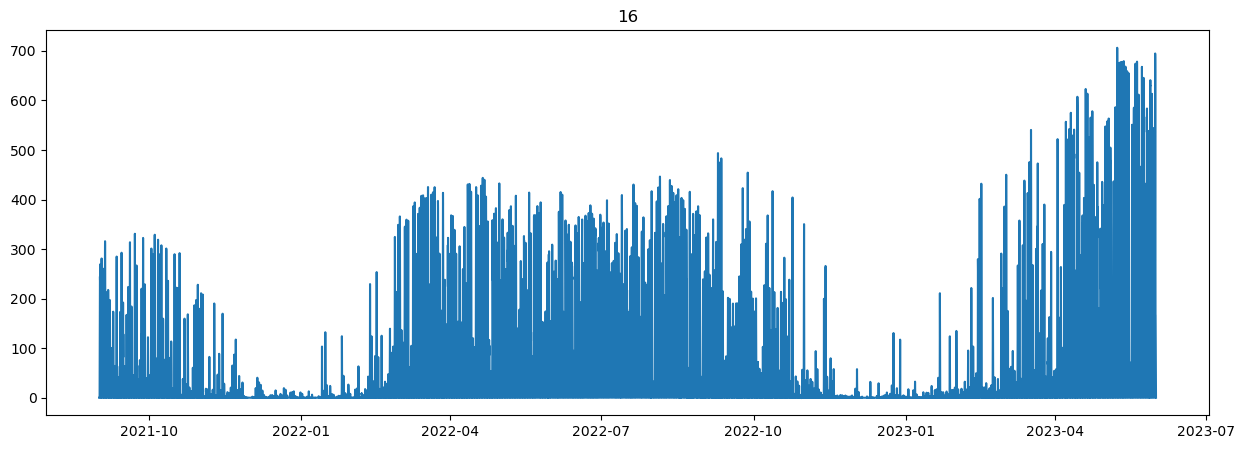

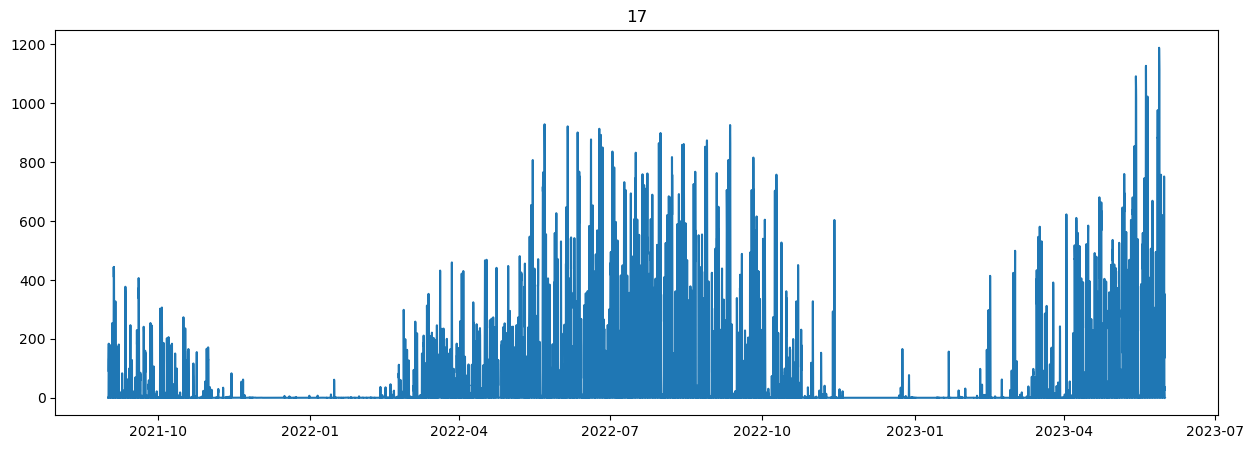

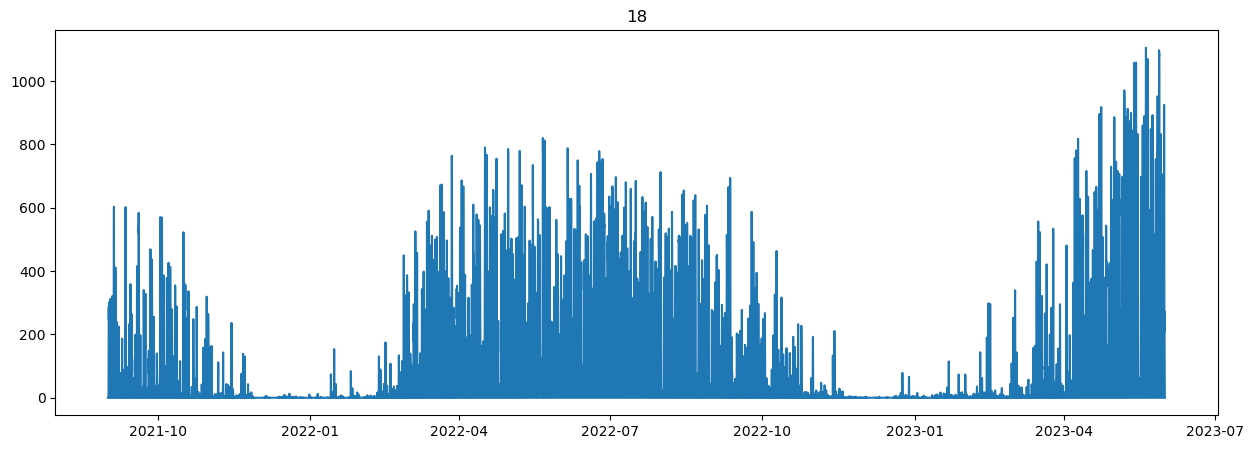

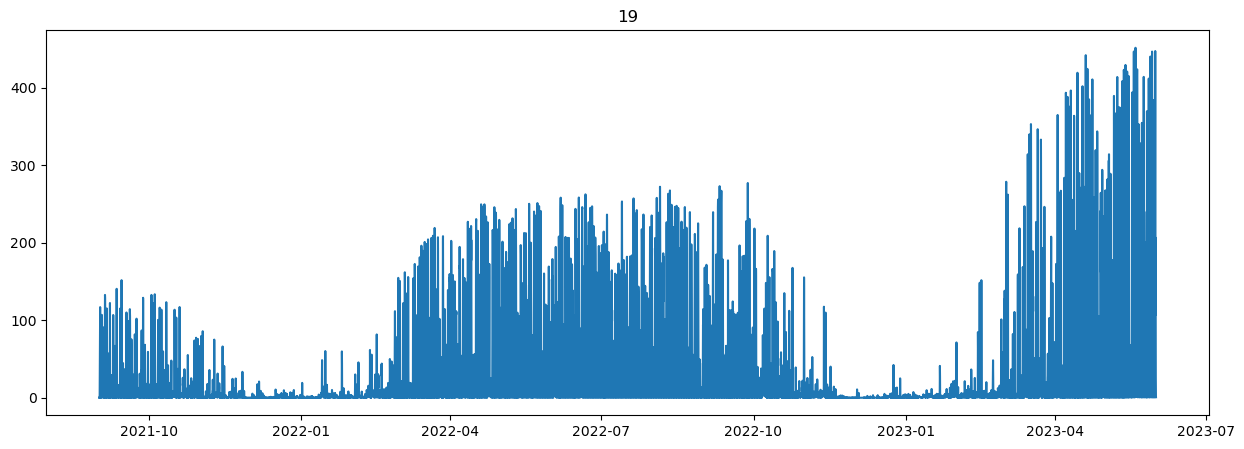

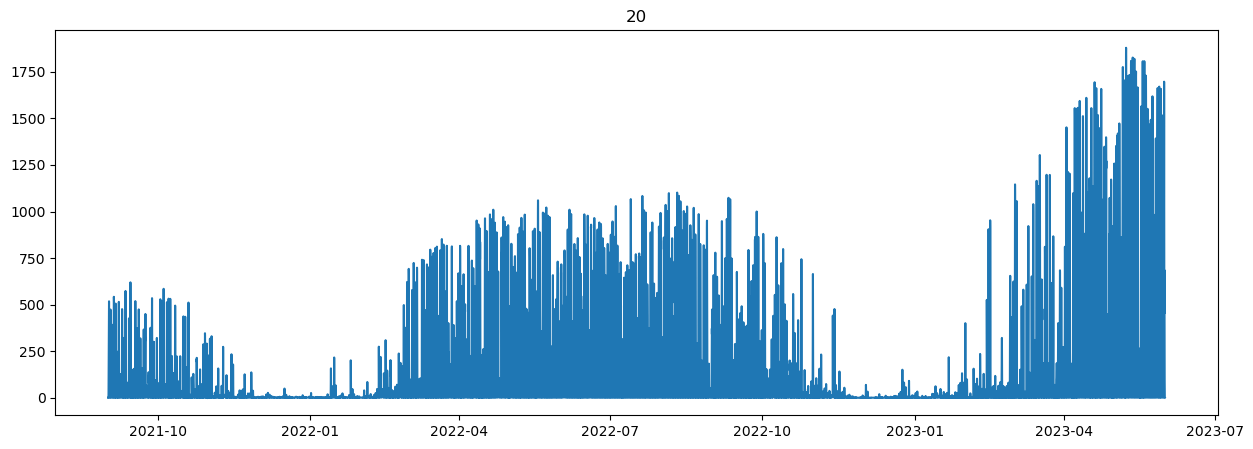

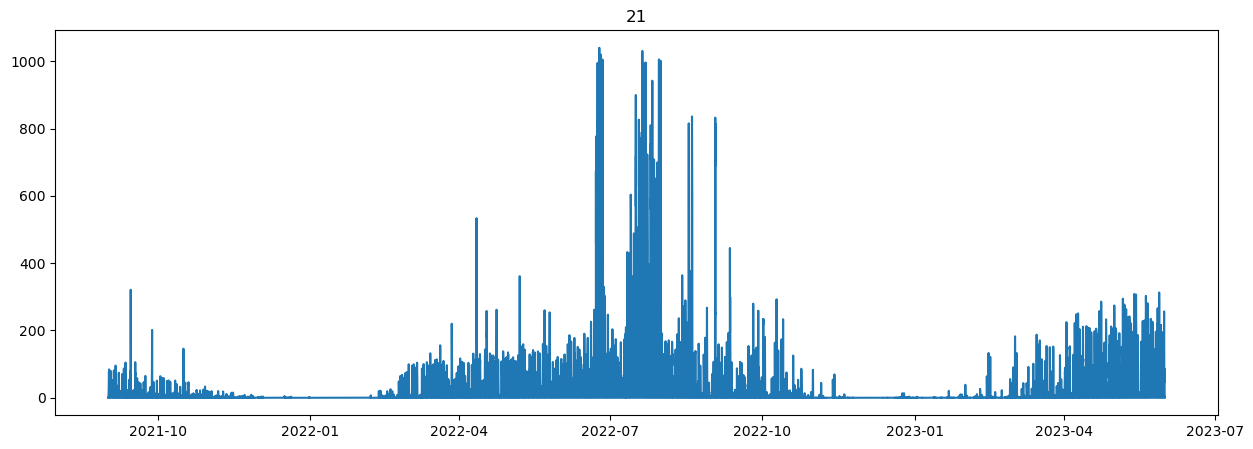

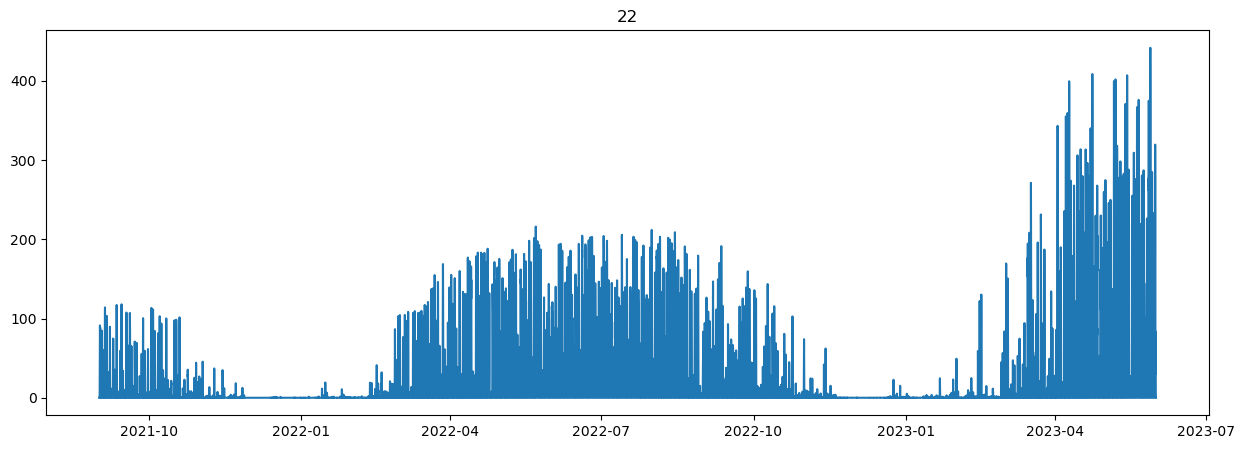

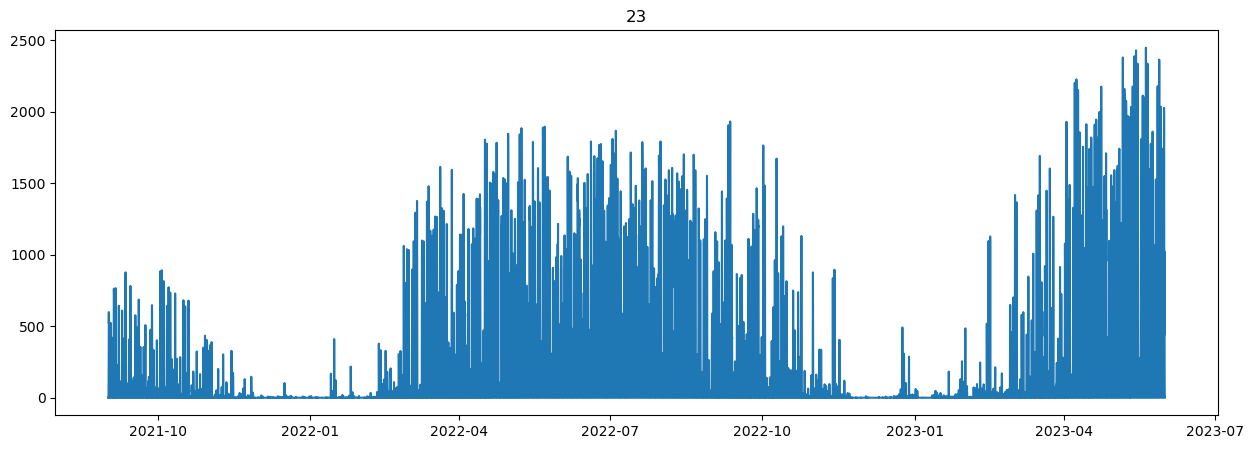

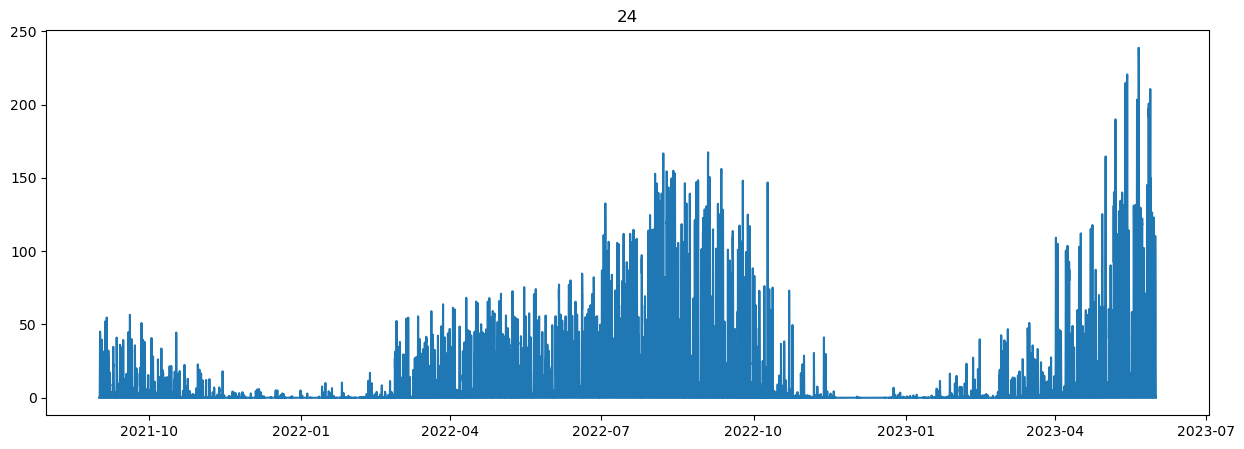

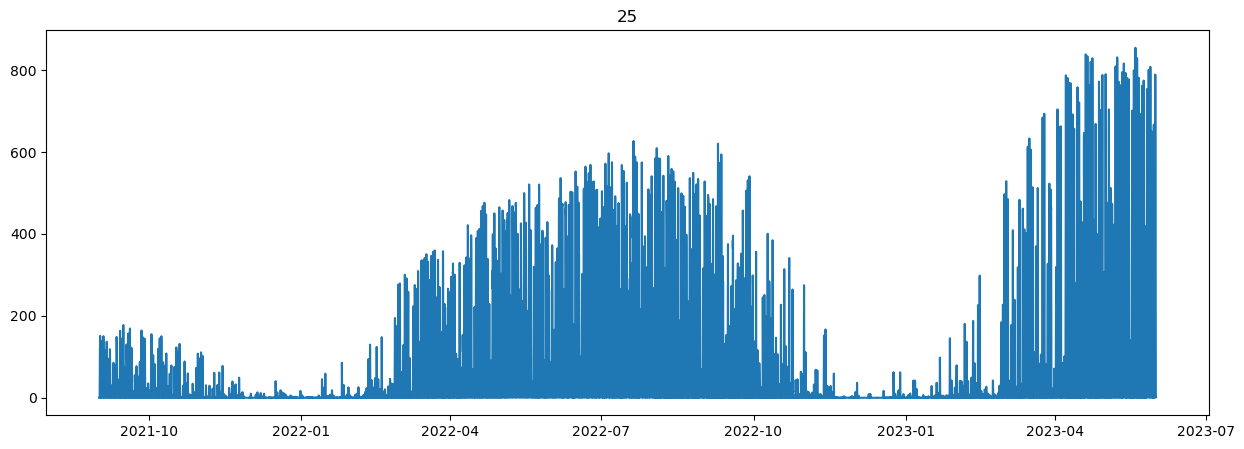

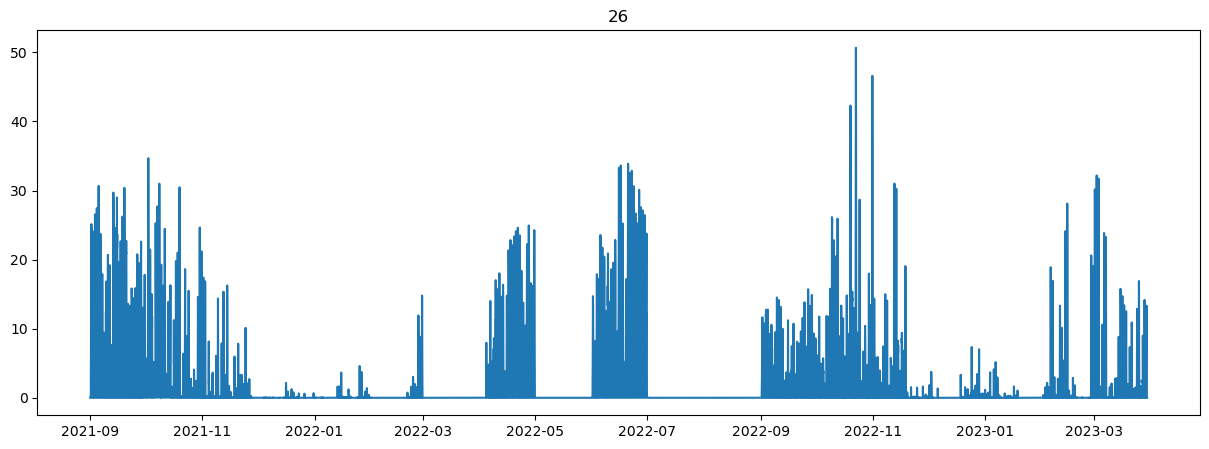

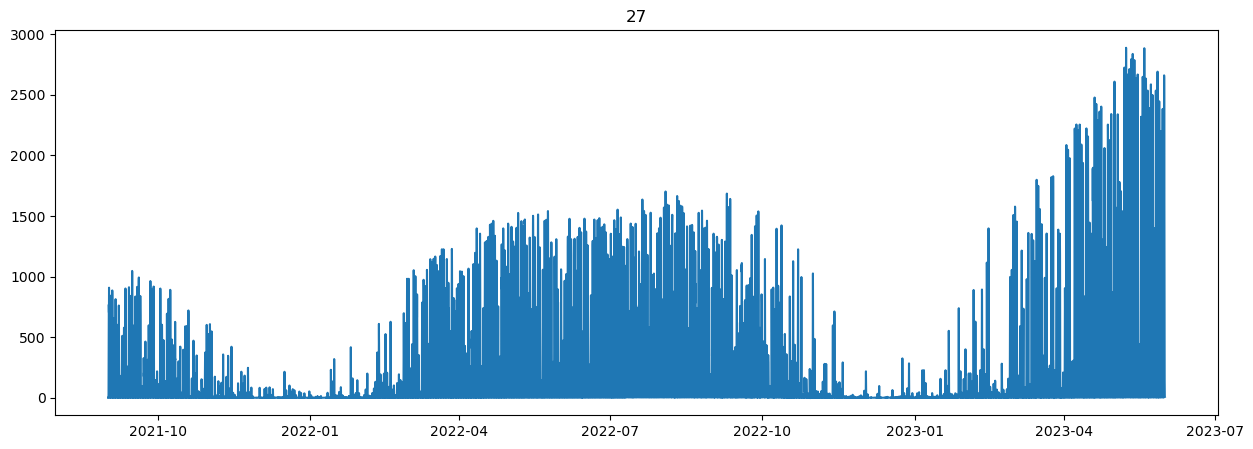

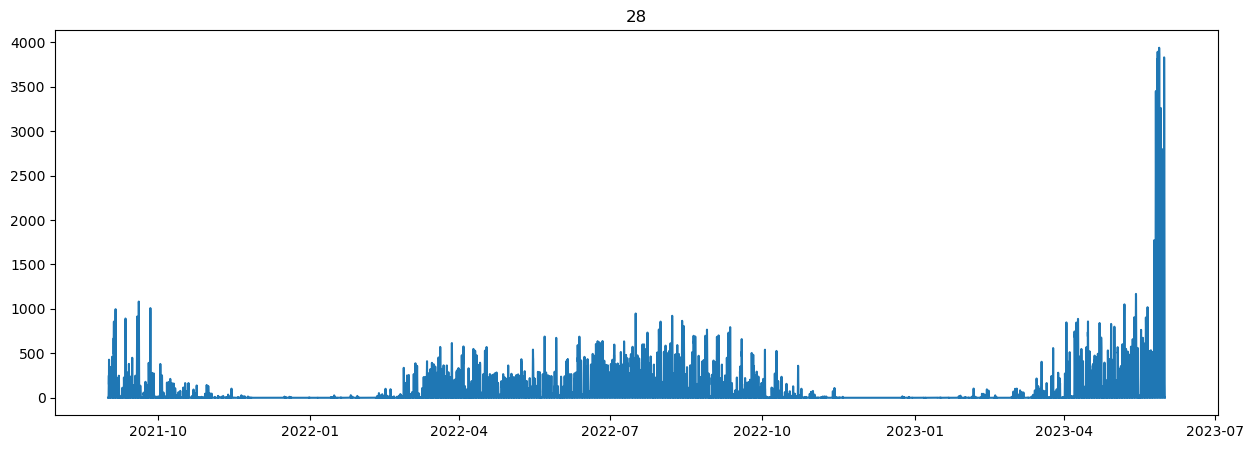

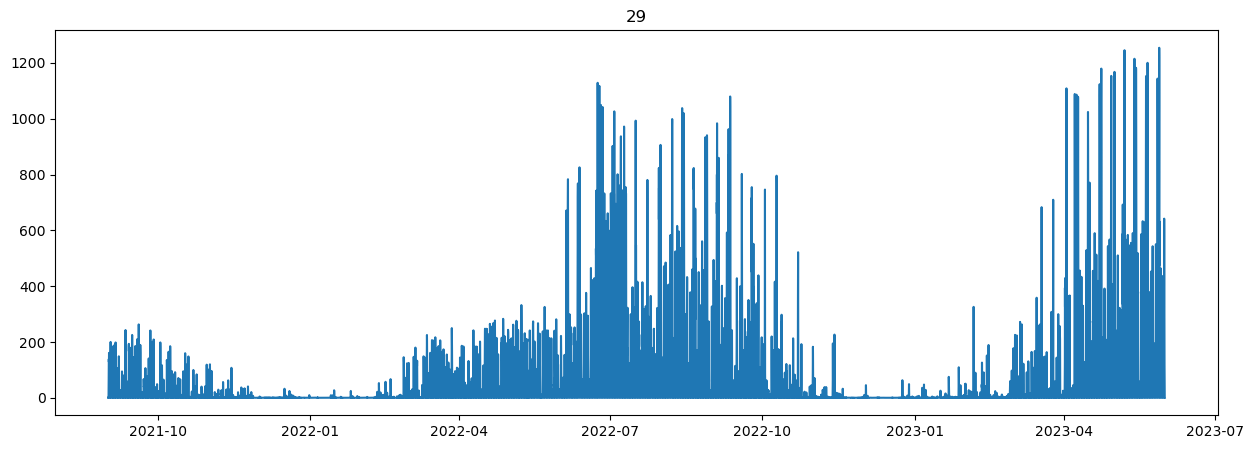

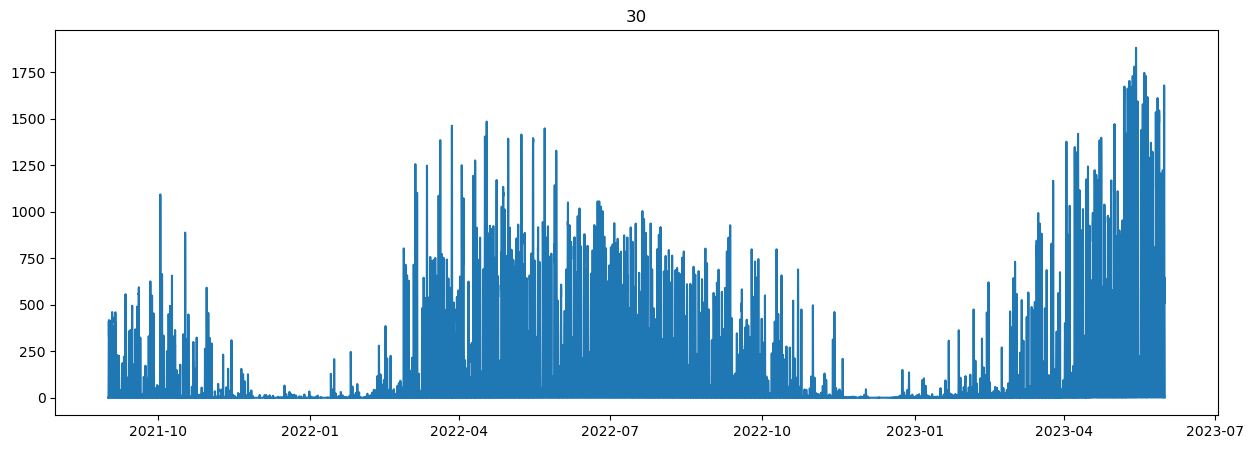

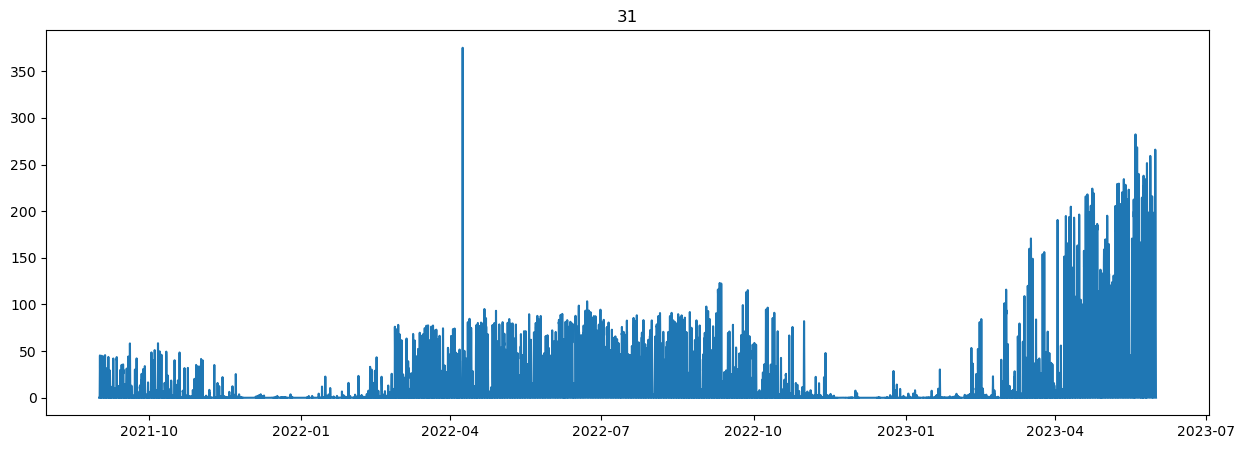

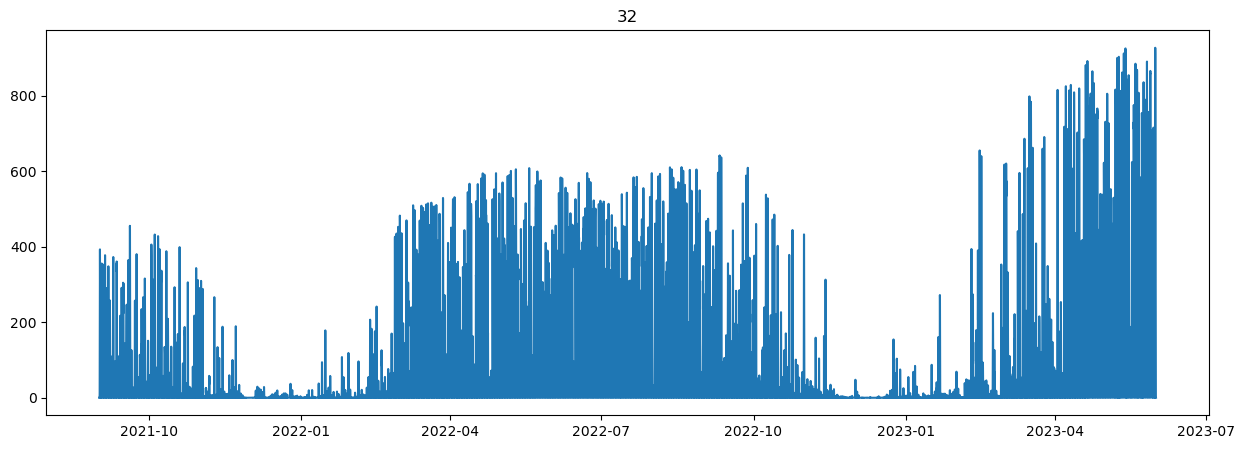

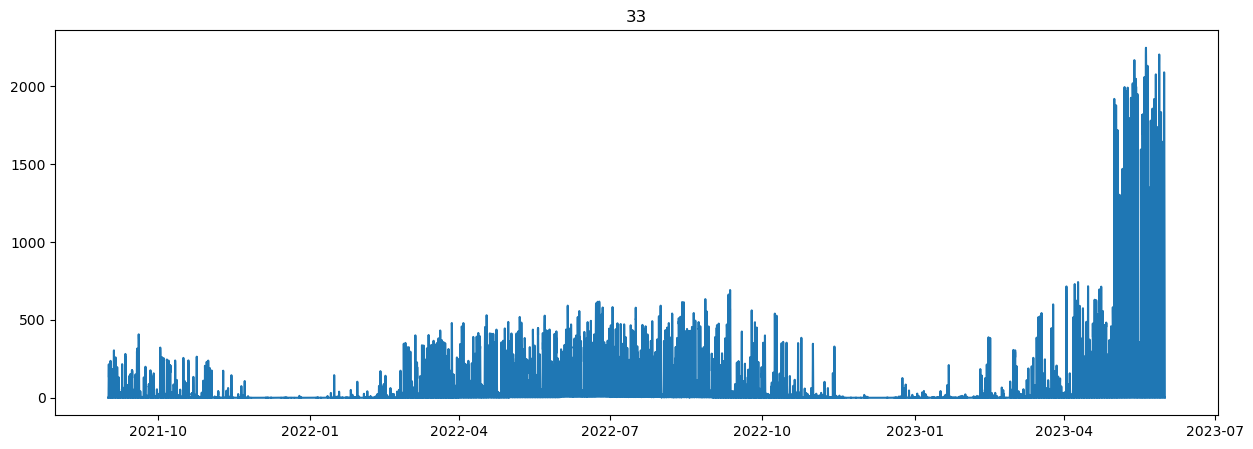

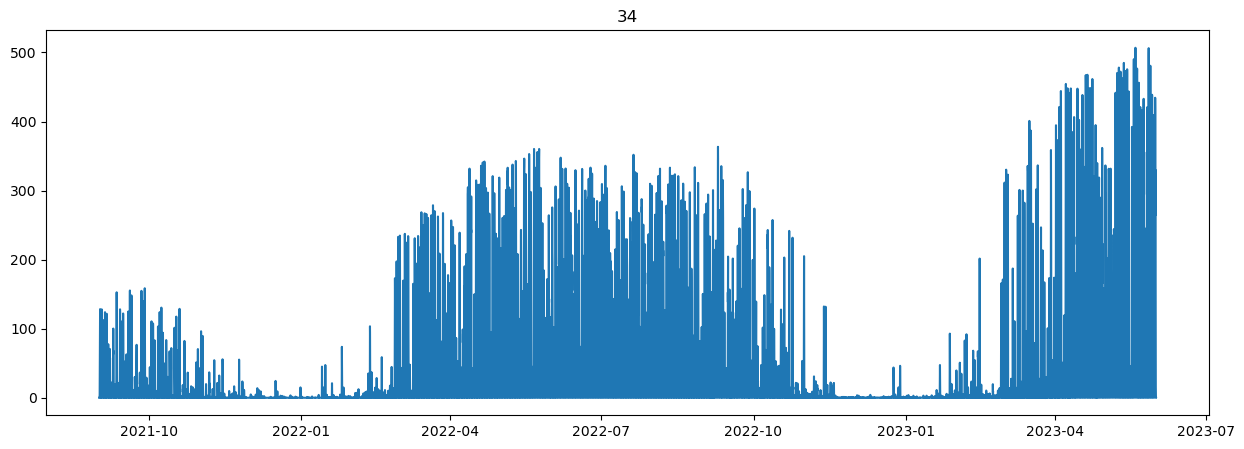

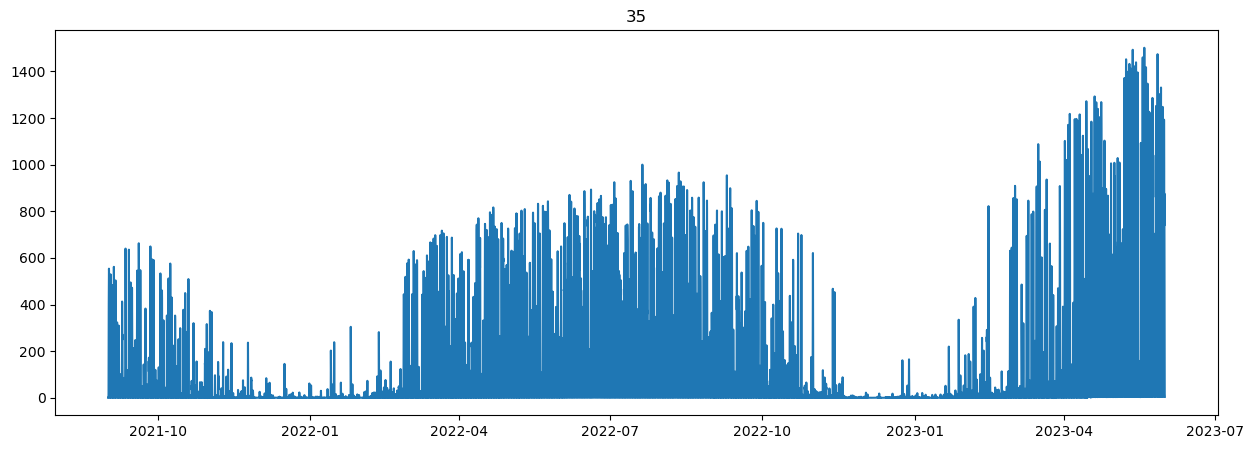

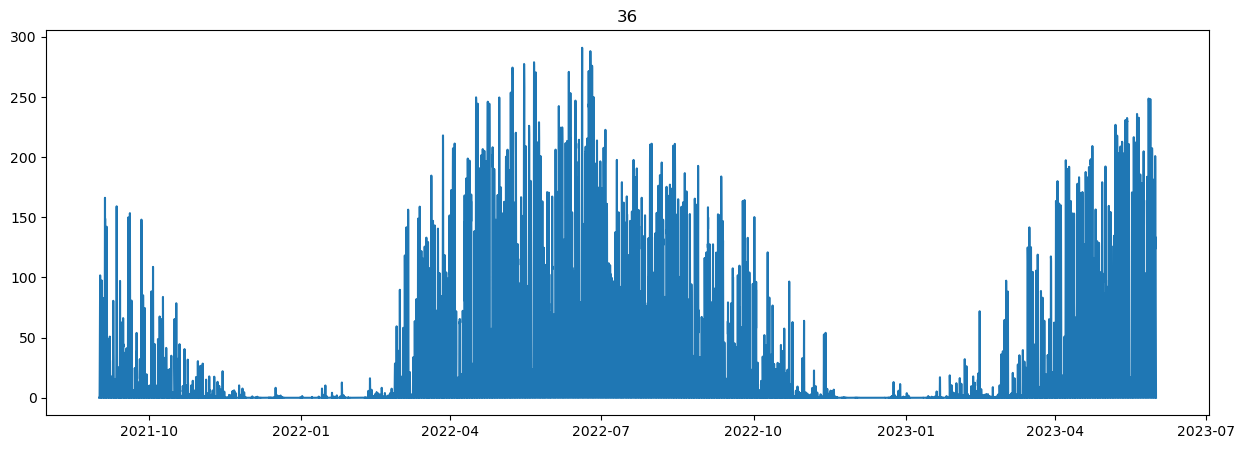

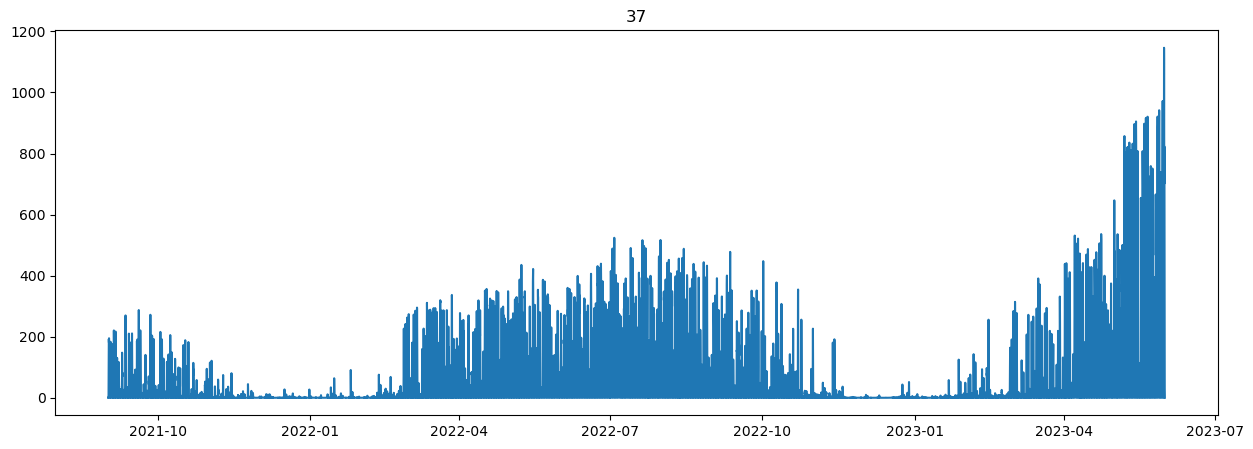

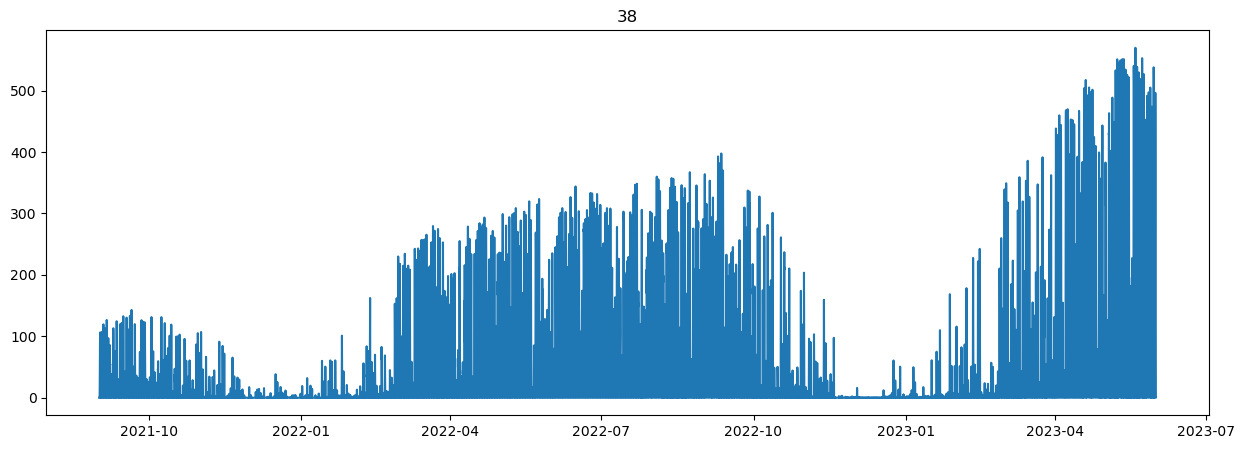

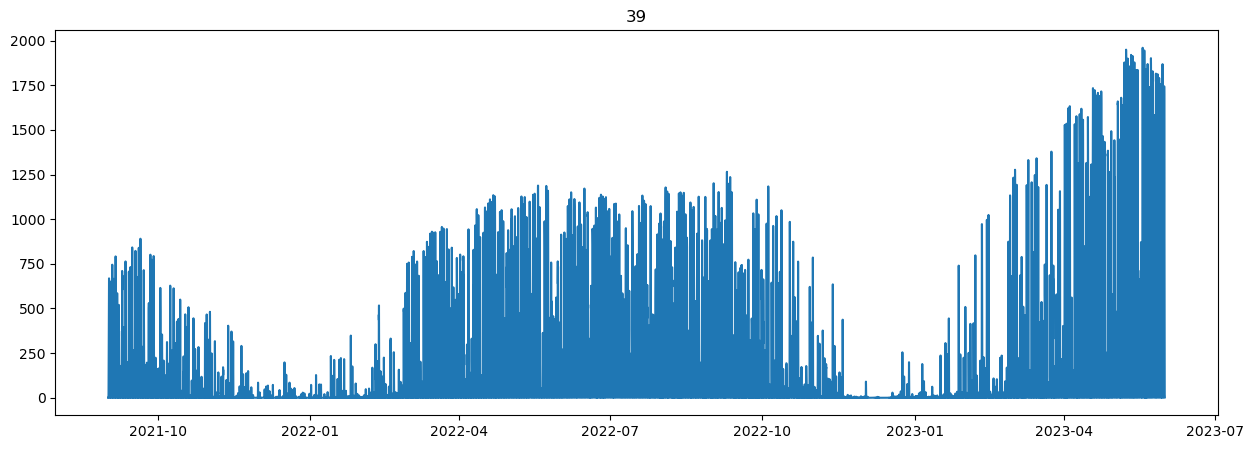

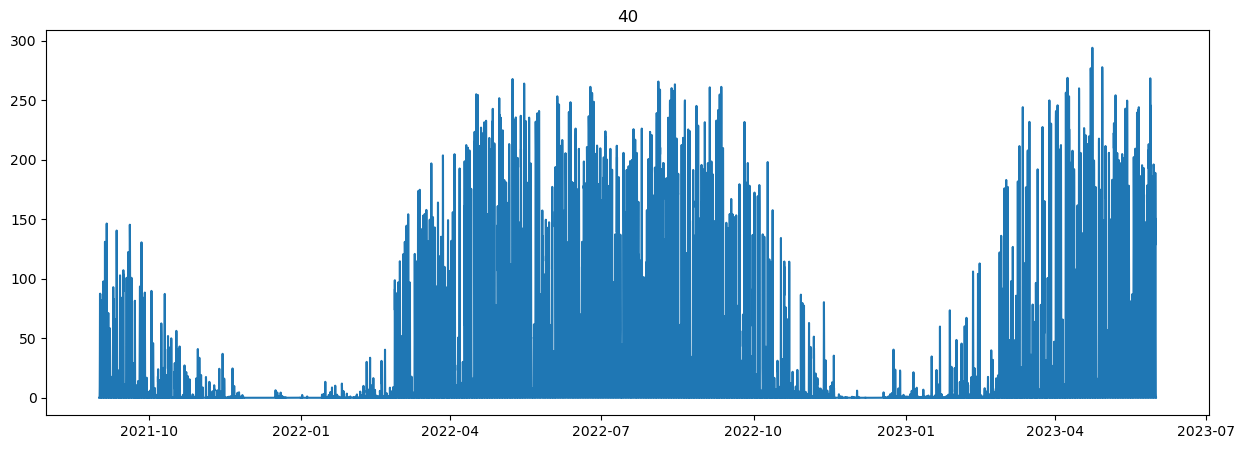

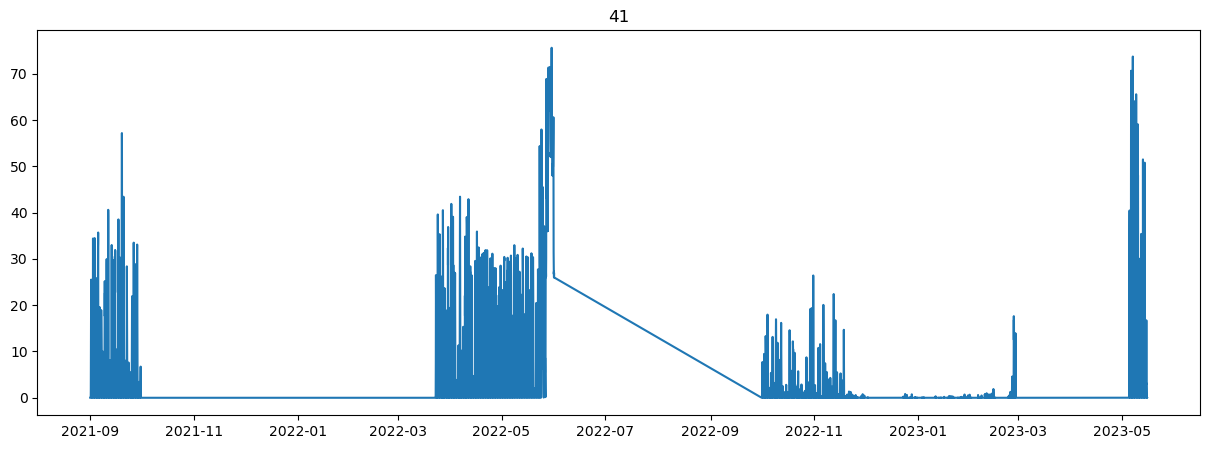

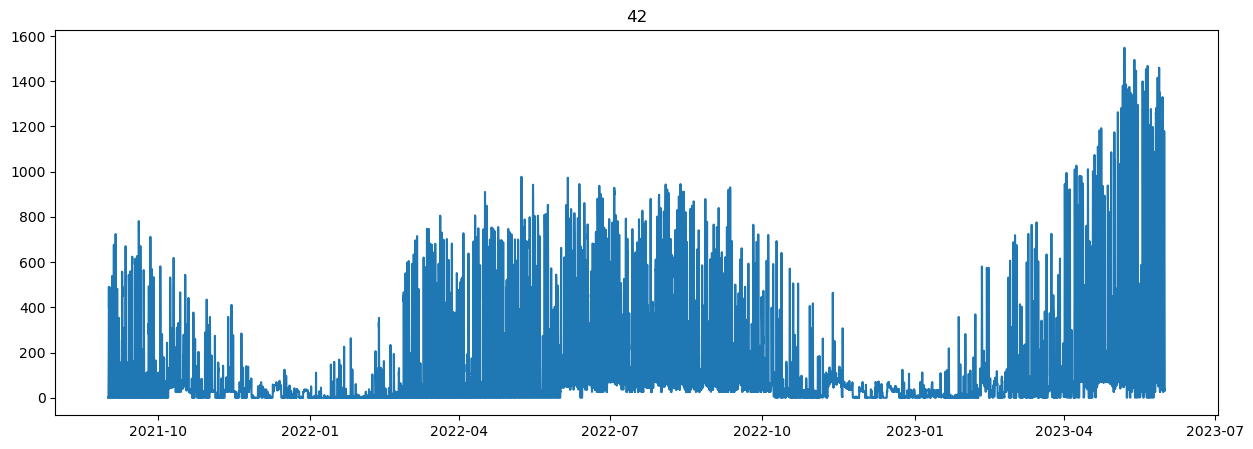

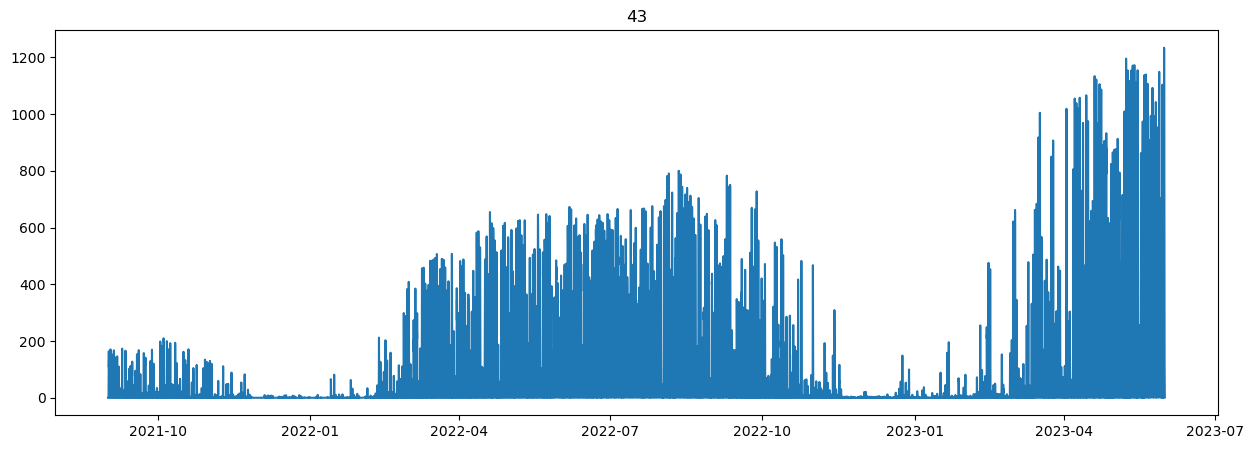

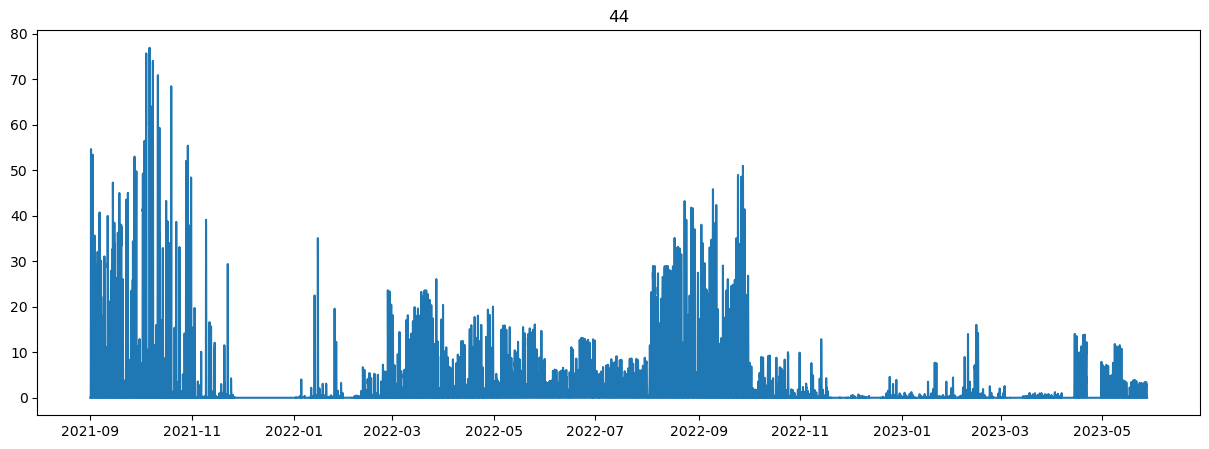

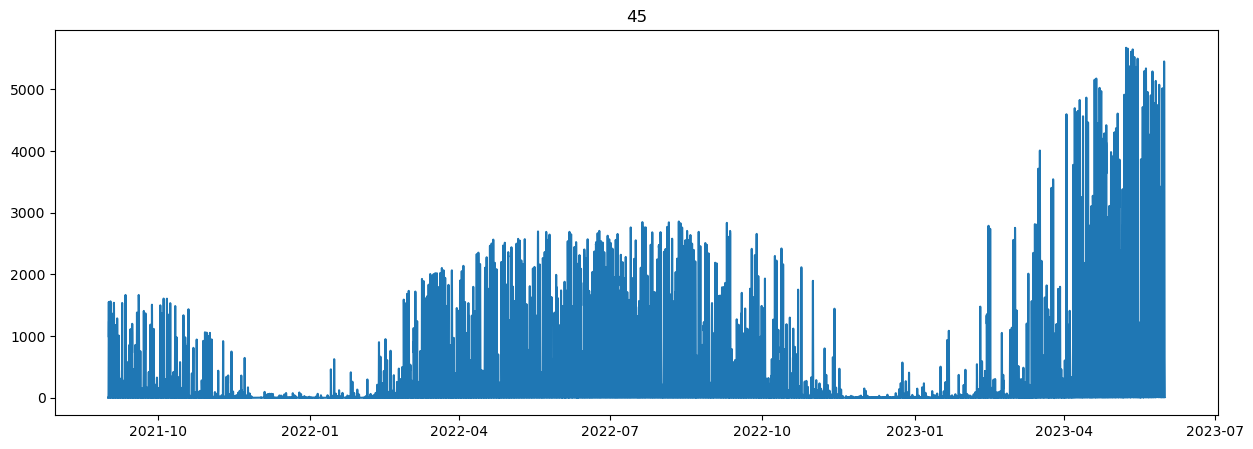

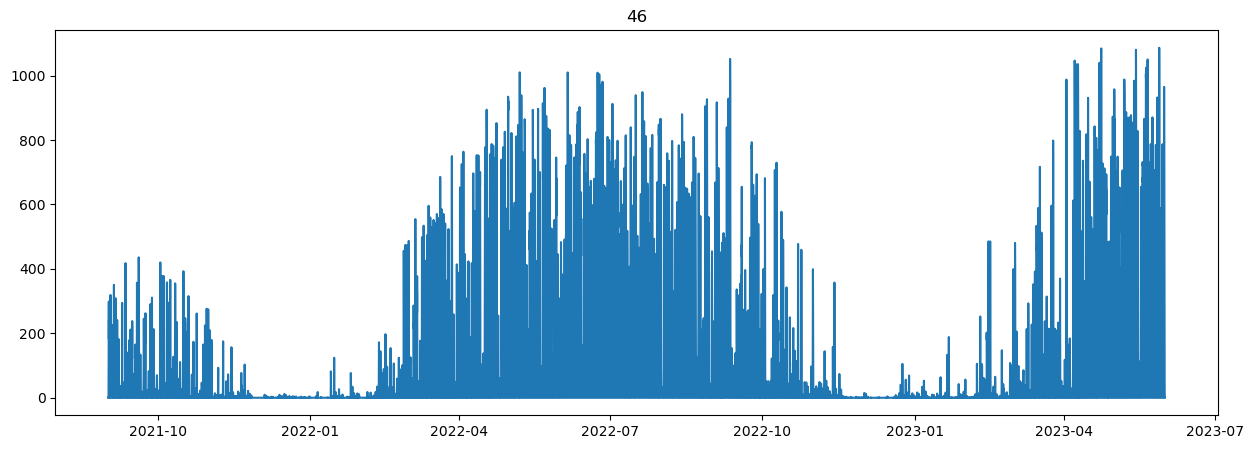

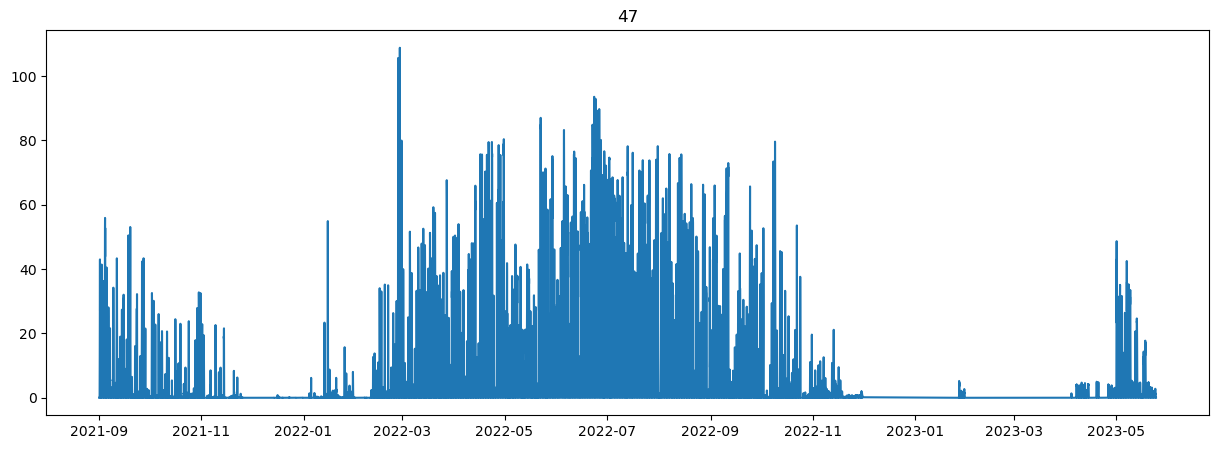

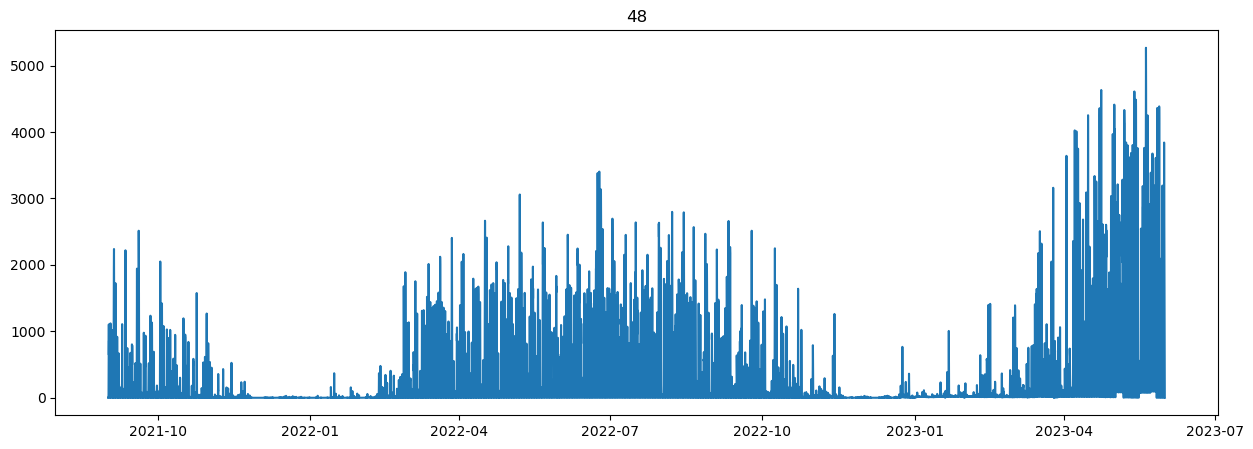

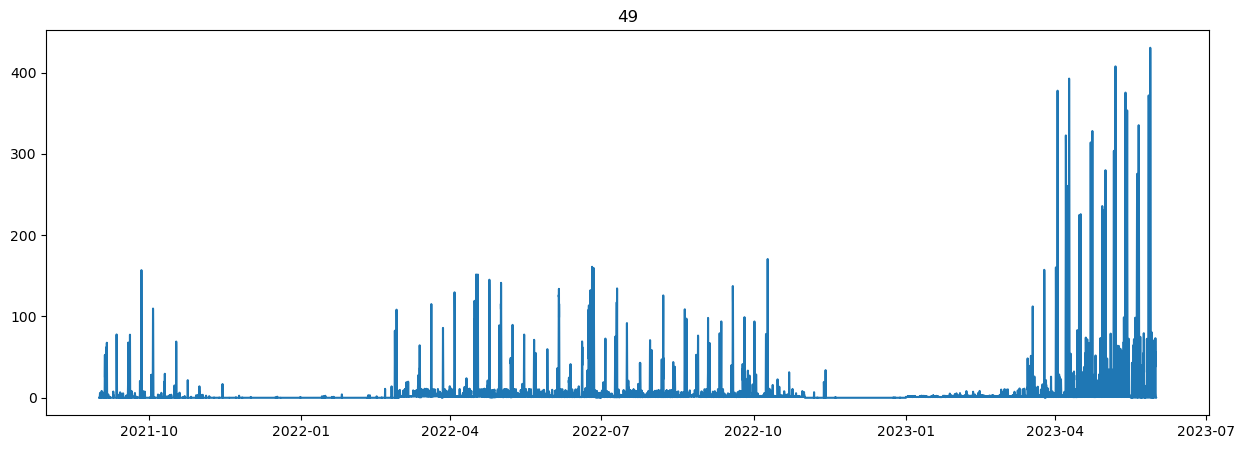

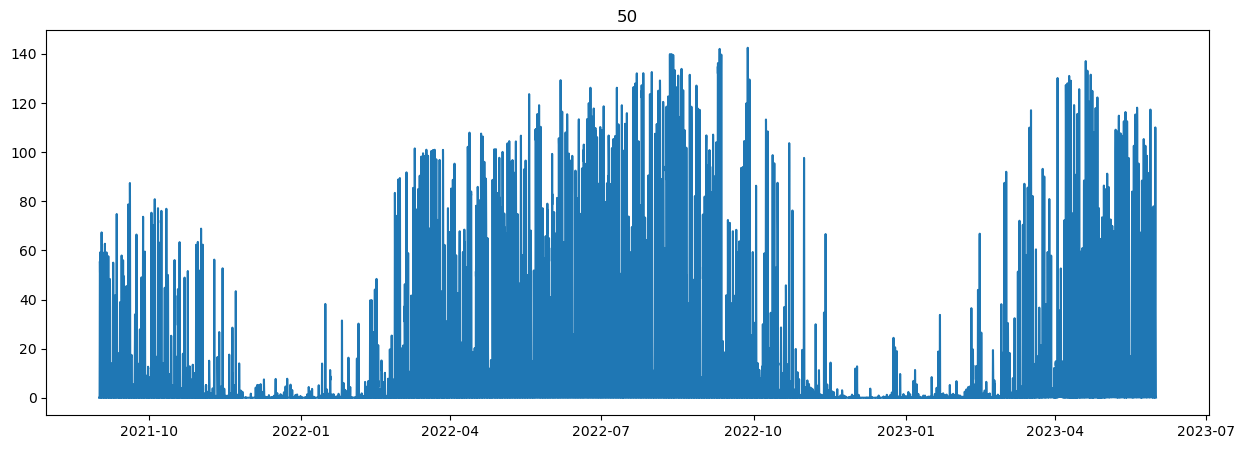

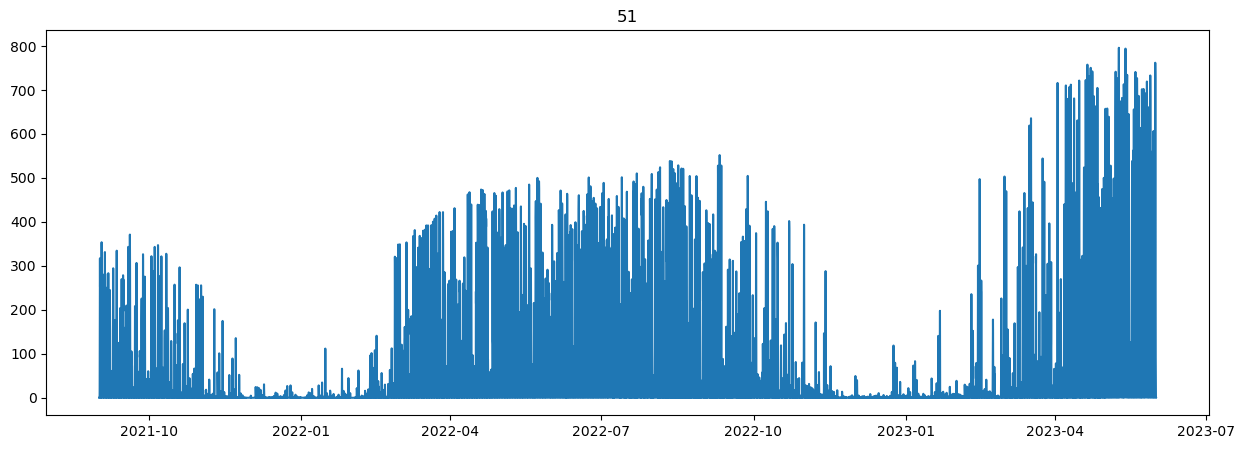

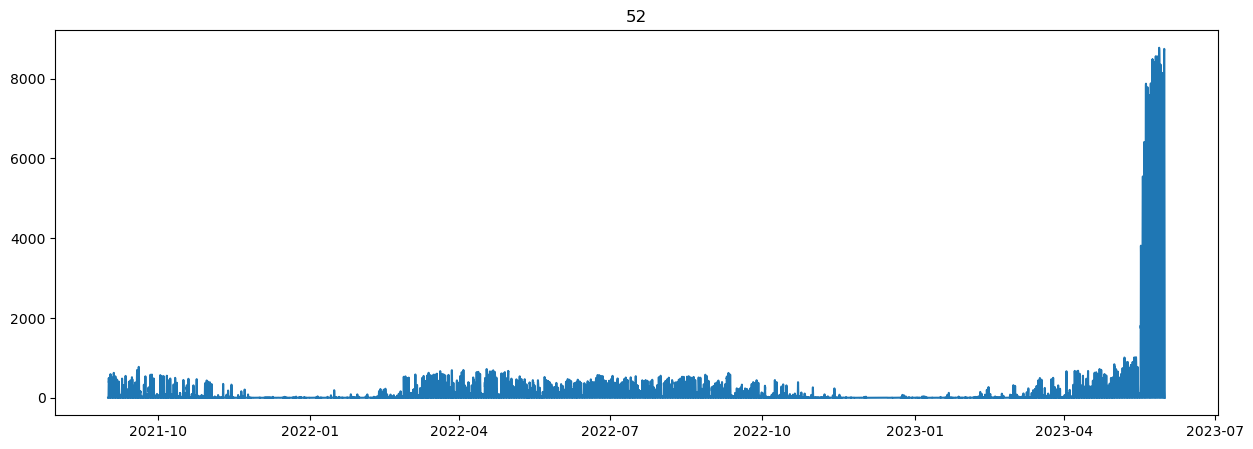

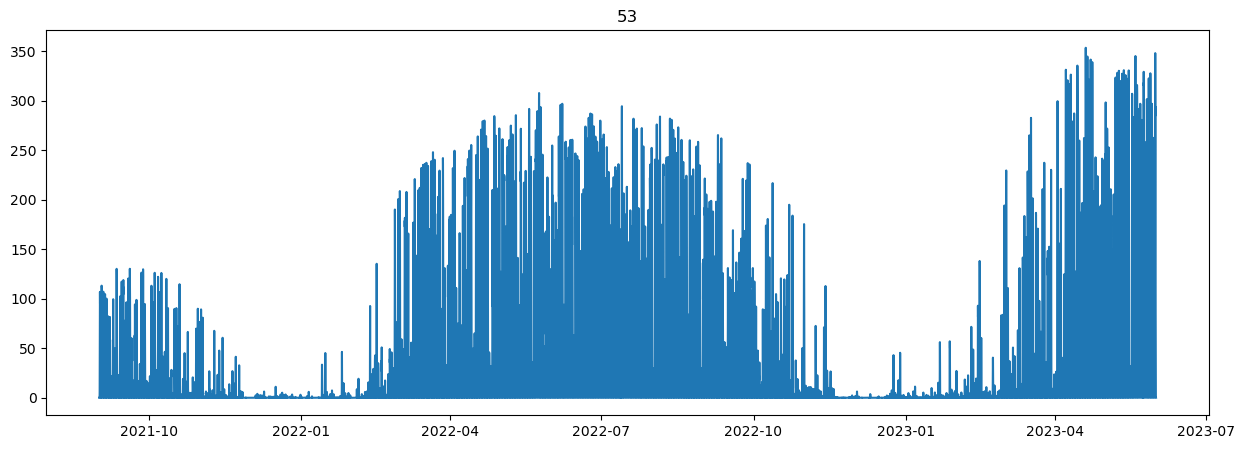

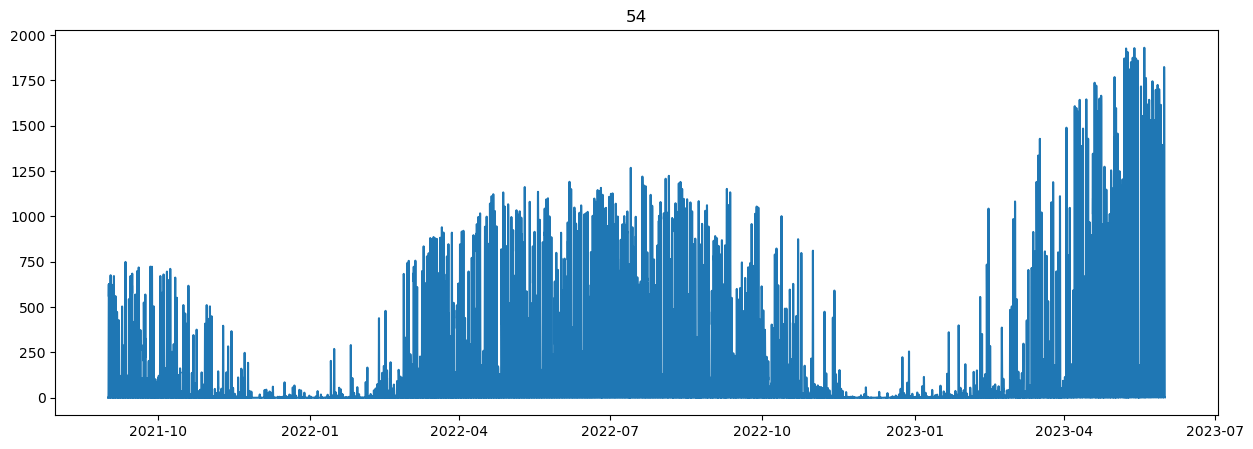

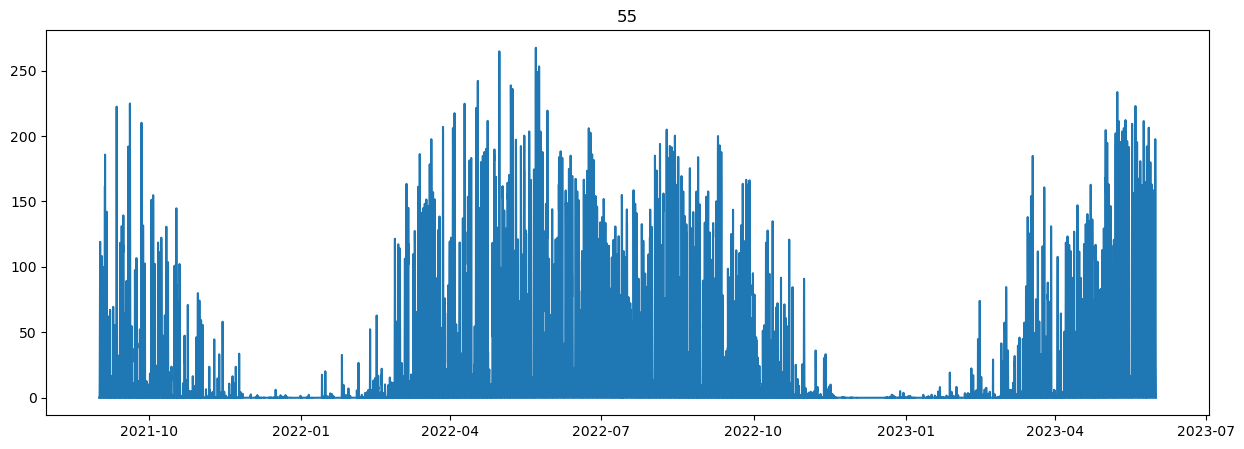

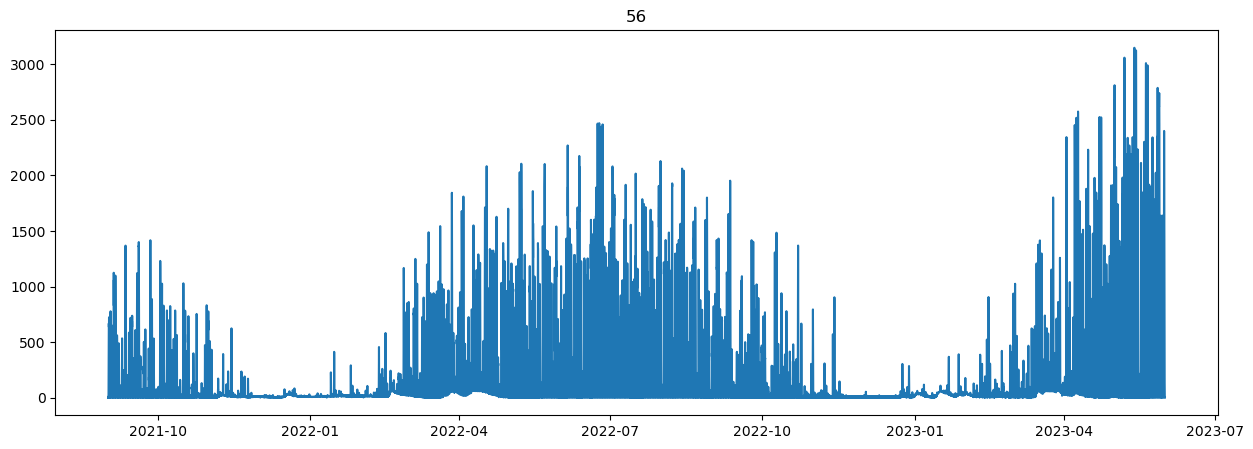

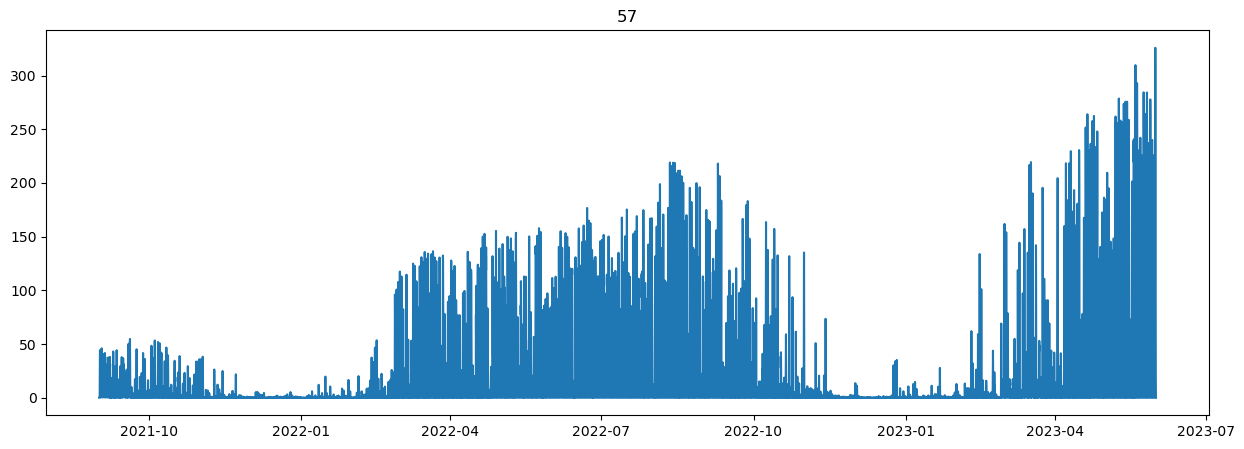

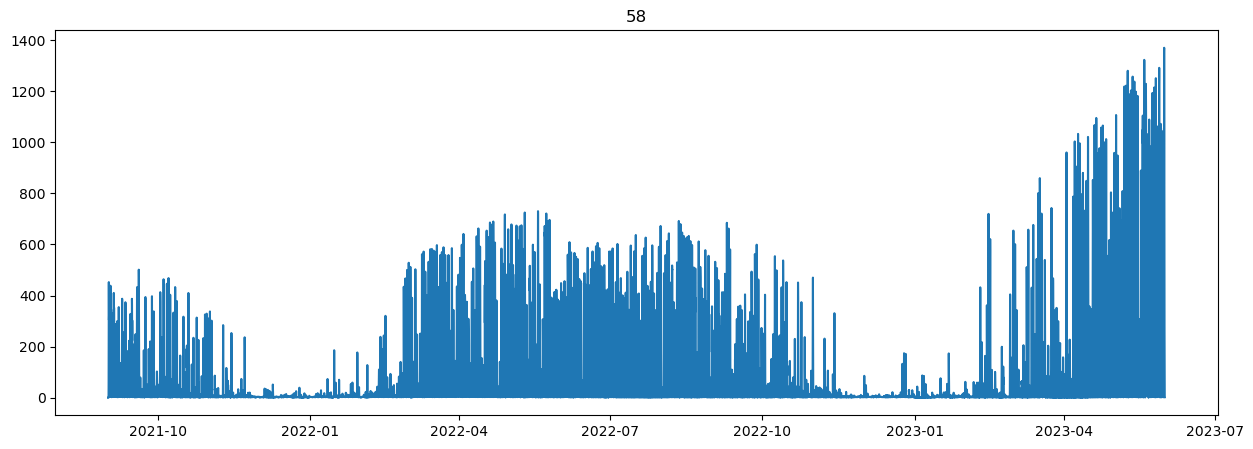

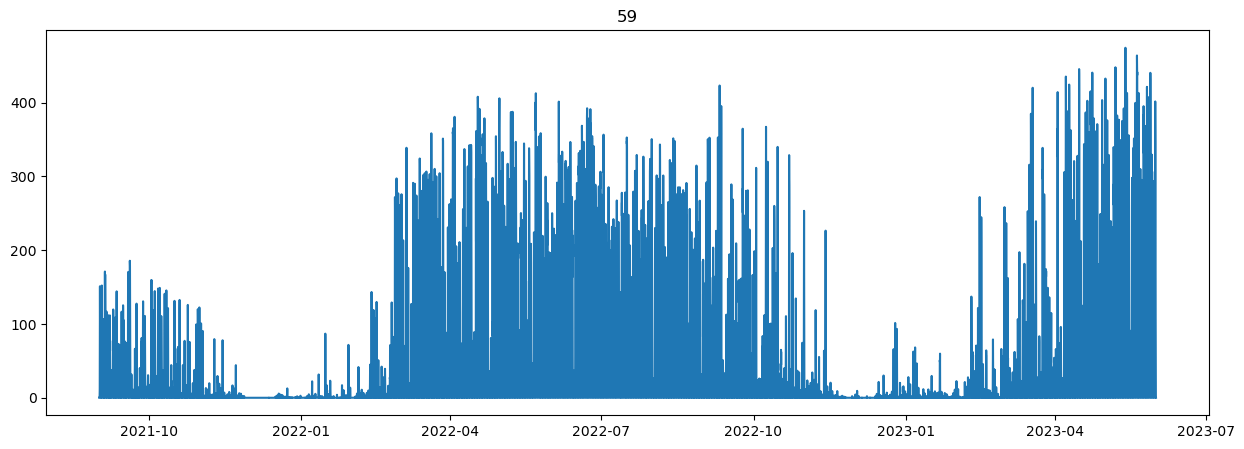

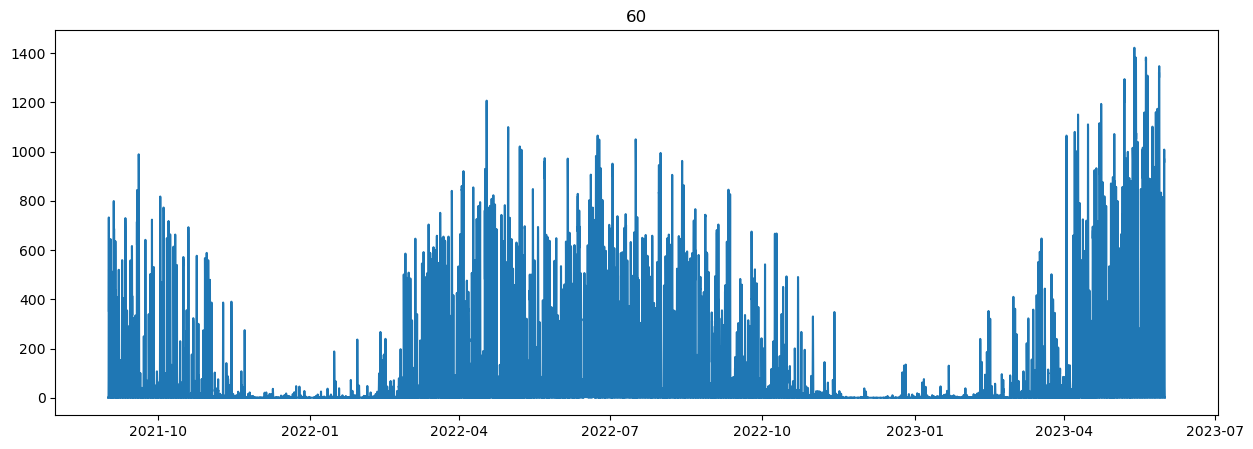

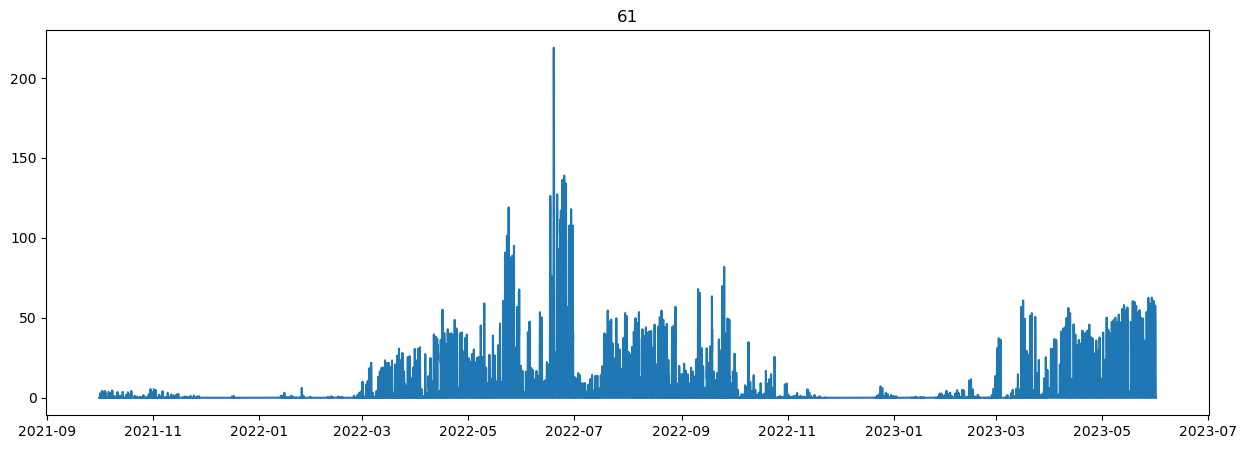

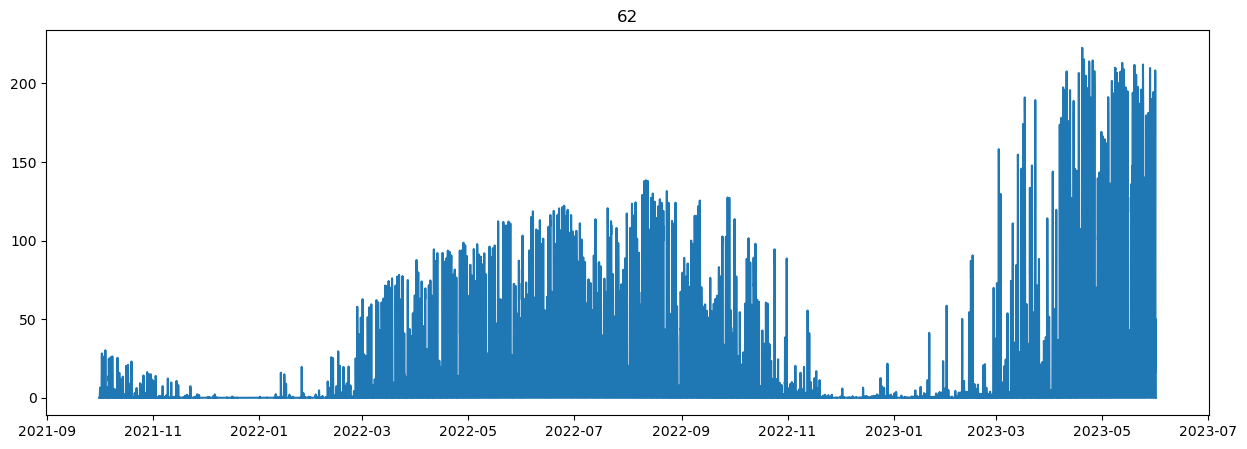

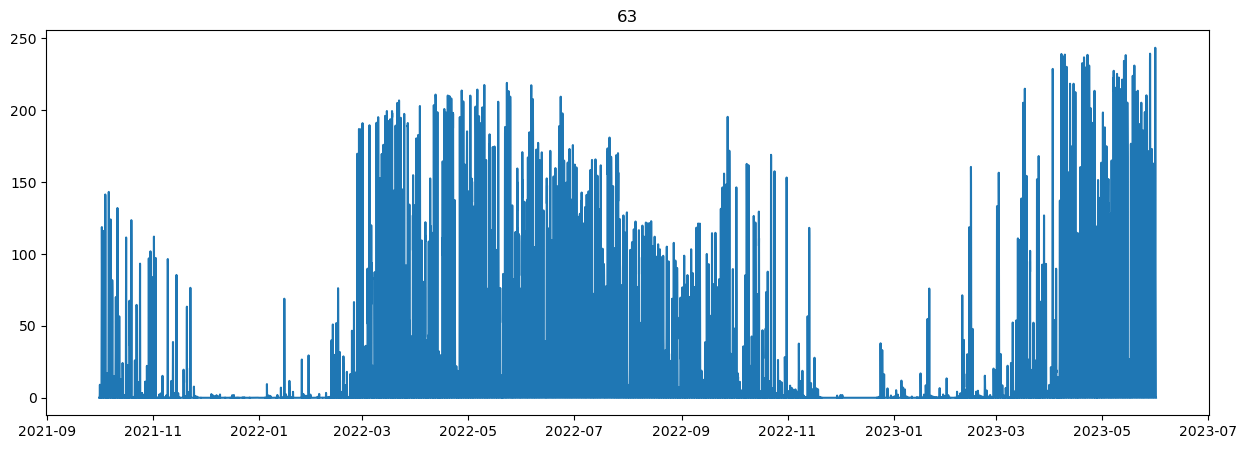

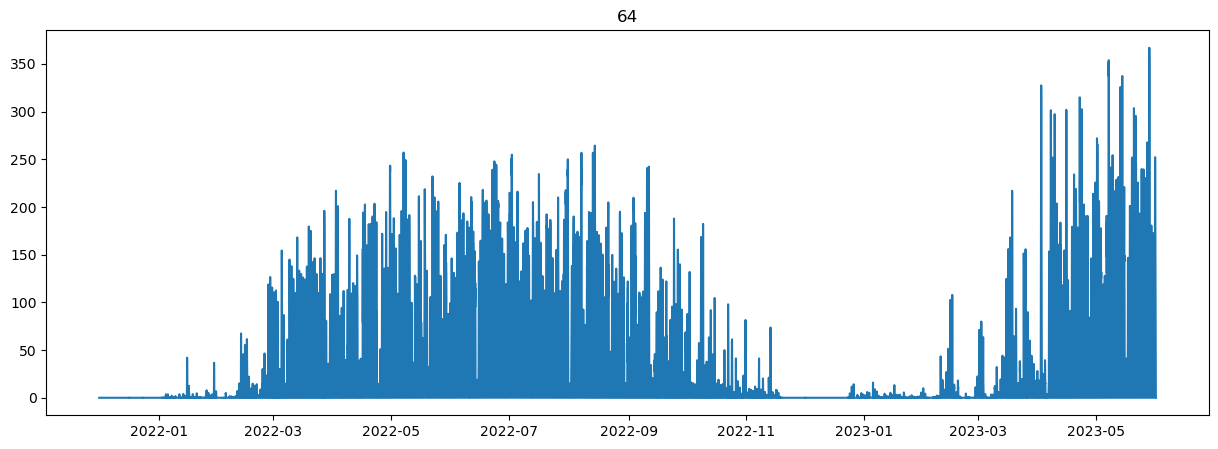

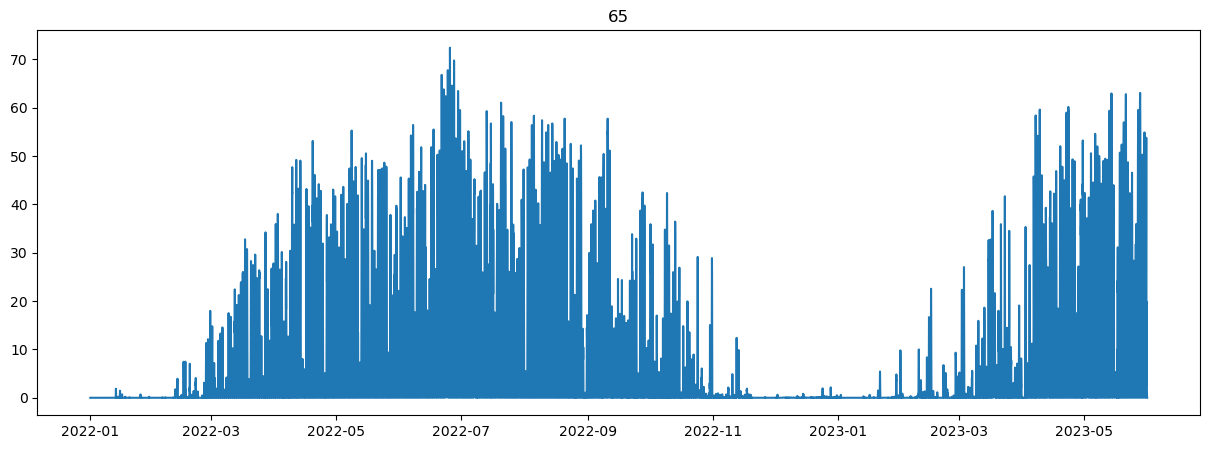

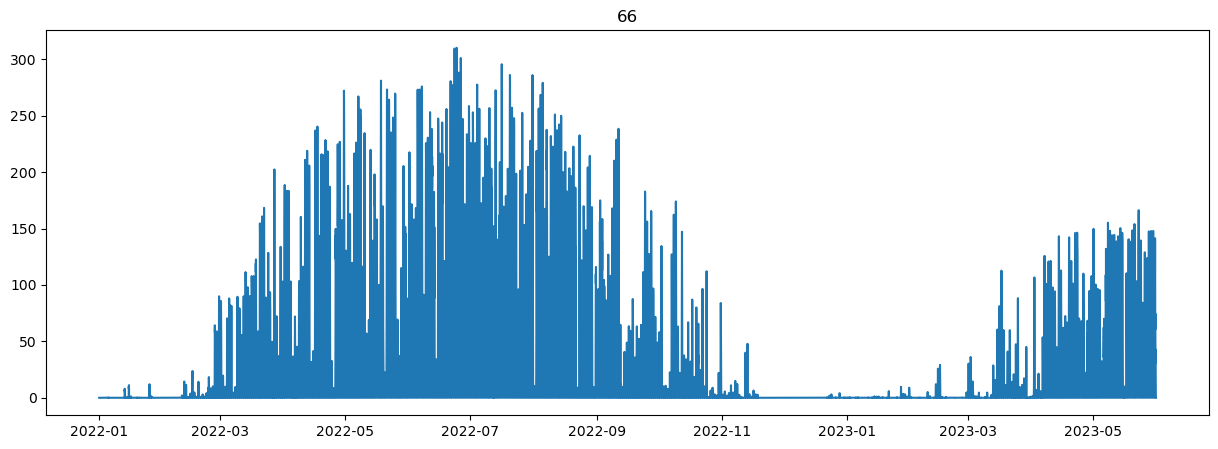

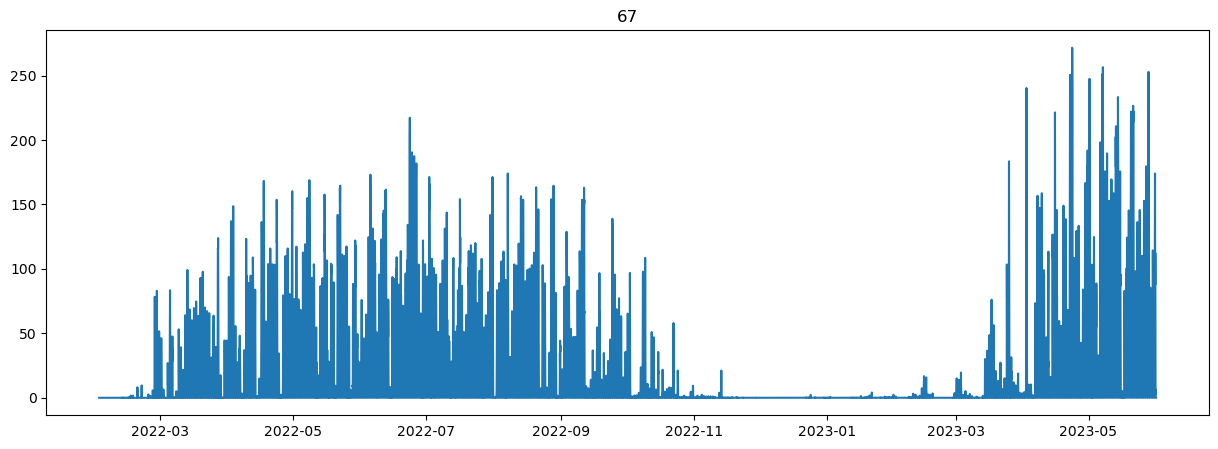

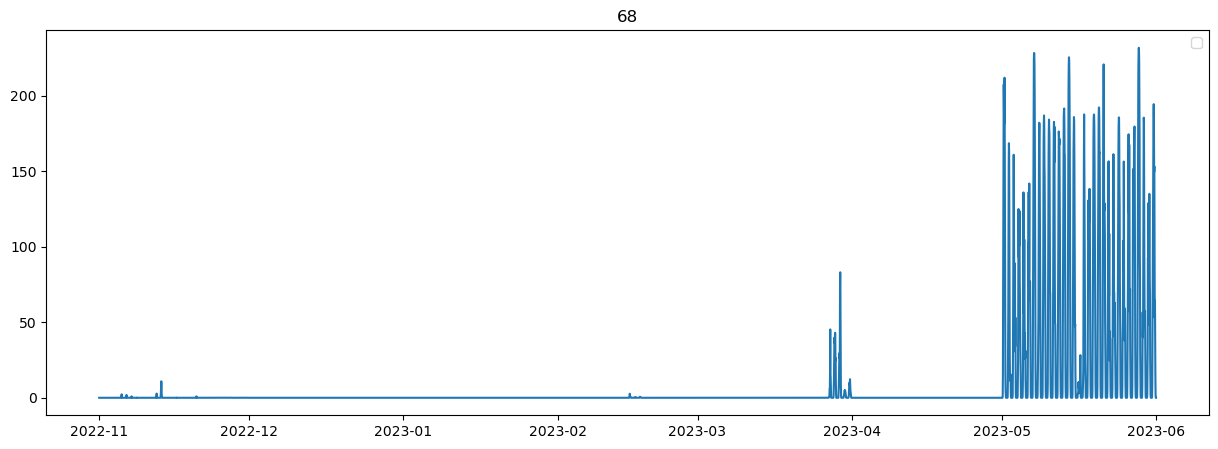

In [16]:
# county별로 살펴보기
df_produce = df[df['is_consumption']==0]
plt.figure(figsize=(15,5))
for i in range(len(df['prediction_unit_id'].unique())):
    plt.figure(figsize=(15,5))
    plt.plot(df_produce[df_produce['prediction_unit_id']==i]['target'])
    plt.title(i)
plt.legend()

In [16]:
# target값이 0인 행 출력 => null값으로 봐야하는 것인지 확인
df_produce[df_produce['target']==0]

county  is_business  product_type  target  \
datetime                                                         
2021-09-01 00:00:00       0            0             2     0.0   
2021-09-01 00:00:00       0            1             0     0.0   
2021-09-01 00:00:00       0            1             1     0.0   
2021-09-01 00:00:00       1            0             1     0.0   
2021-09-01 00:00:00       1            1             3     0.0   
...                     ...          ...           ...     ...   
2023-05-31 23:00:00      14            1             1     0.0   
2023-05-31 23:00:00      14            1             2     0.0   
2023-05-31 23:00:00      15            1             0     0.0   
2023-05-31 23:00:00      15            1             1     0.0   
2023-05-31 23:00:00      15            1             3     0.0   

                     is_consumption            datetime  data_block_id  \
datetime                                                                 
2021-09-01 00:00:00               0 2021-09-01 00:00:00              0   
2021-09-01 00:00:00               0 2021-09-01 00:00:00              0   
2021-09-01 00:00:00               0 2021-09-01 00:00:00              0   
2021-09-01 00:00:00               0 2021-09-01 00:00:00              0   
2021-09-01 00:00:00               0 2021-09-01 00:00:00              0   
...                             ...                 ...            ...   
2023-05-31 23:00:00               0 2023-05-31 23:00:00            637   
2023-05-31 23:00:00               0 2023-05-31 23:00:00            637   
2023-05-31 23:00:00               0 2023-05-31 23:00:00            637   
2023-05-31 23:00:00               0 2023-05-31 23:00:00            637   
2023-05-31 23:00:00               0 2023-05-31 23:00:00            637   

                      row_id  prediction_unit_id  
datetime                                          
2021-09-01 00:00:00        2                   1  
2021-09-01 00:00:00        6                   3  
2021-09-01 00:00:00        8                   4  
2021-09-01 00:00:00       12                   6  
2021-09-01 00:00:00       16                   8  
...                      ...                 ...  
2023-05-31 23:00:00  2018336                  55  
2023-05-31 23:00:00  2018338                  68  
2023-05-31 23:00:00  2018346                  64  
2023-05-31 23:00:00  2018348                  59  
2023-05-31 23:00:00  2018350                  60  

[351410 rows x 9 columns]

### 에너지 소비량

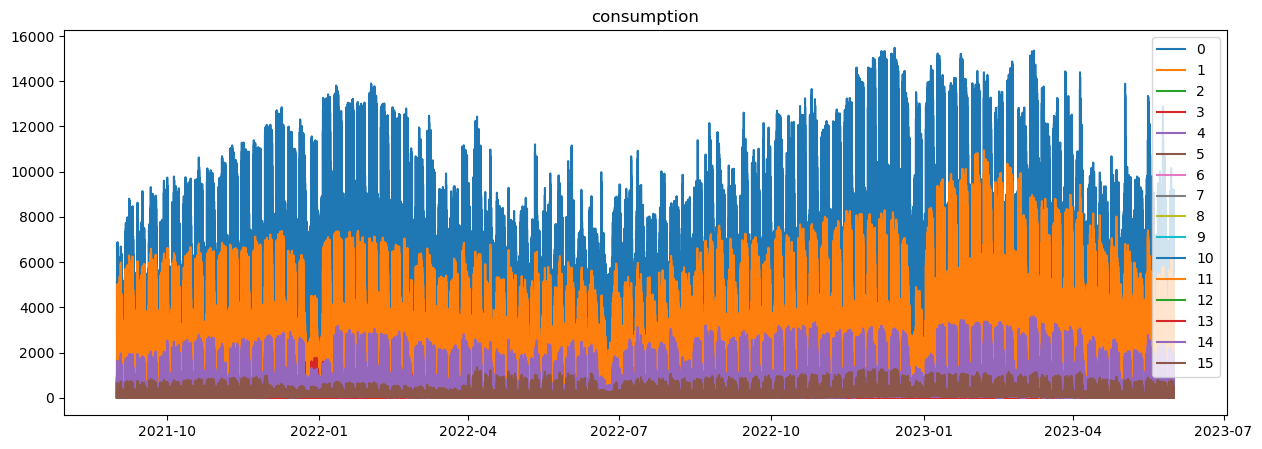

In [17]:
# county별 소비량
df_consumption = df[df['is_consumption']==1]
plt.figure(figsize=(15,5))
for i in range(len(df['county'].unique())):
    plt.plot(df_consumption[df_consumption['county']==i]['target'], label=i)
plt.title('consumption')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1500x500 with 0 Axes>

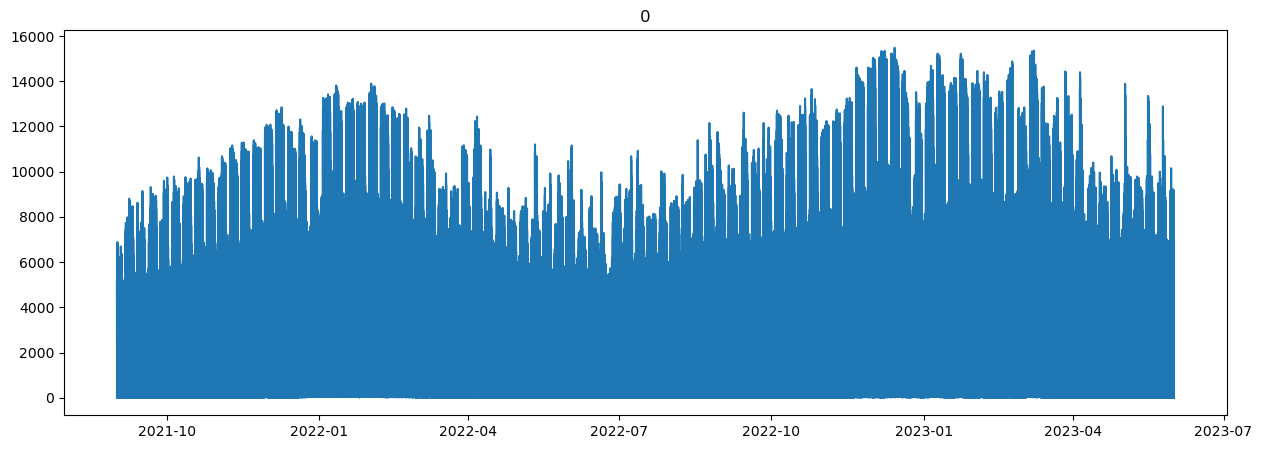

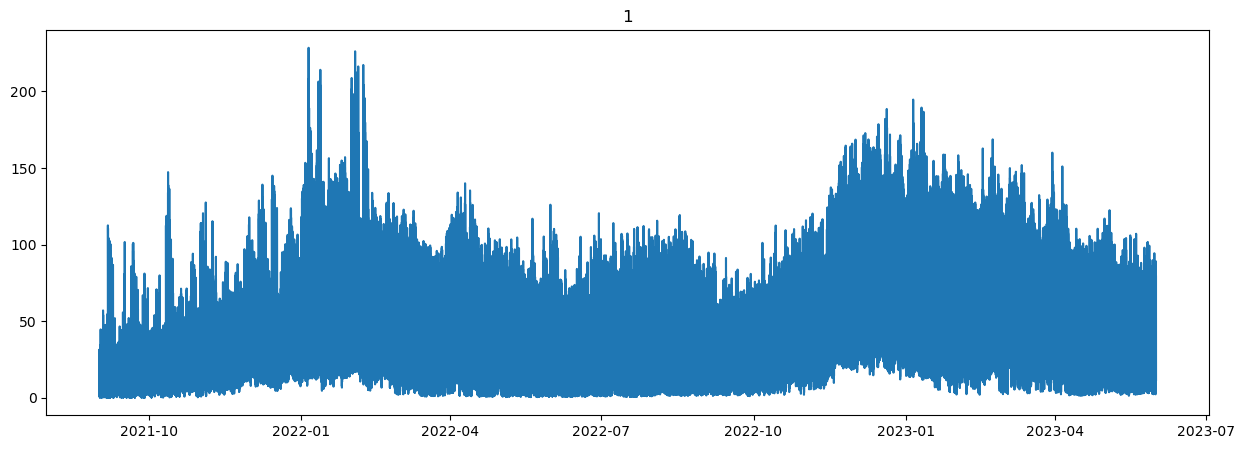

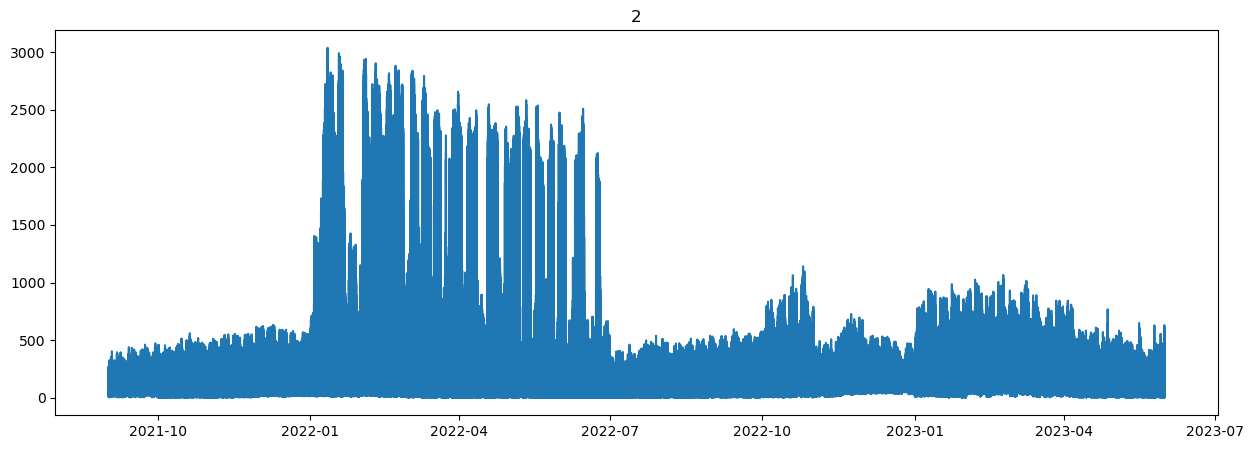

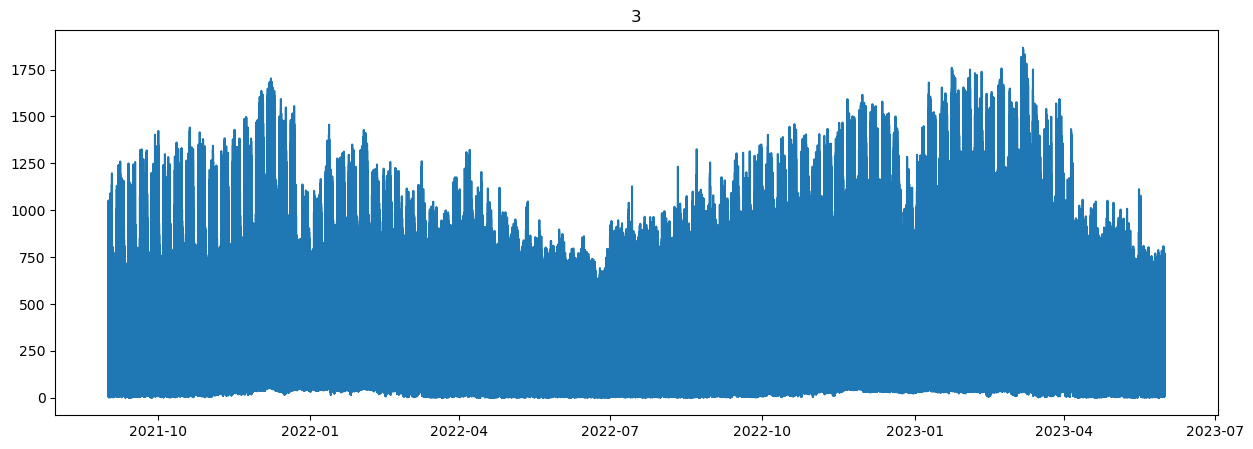

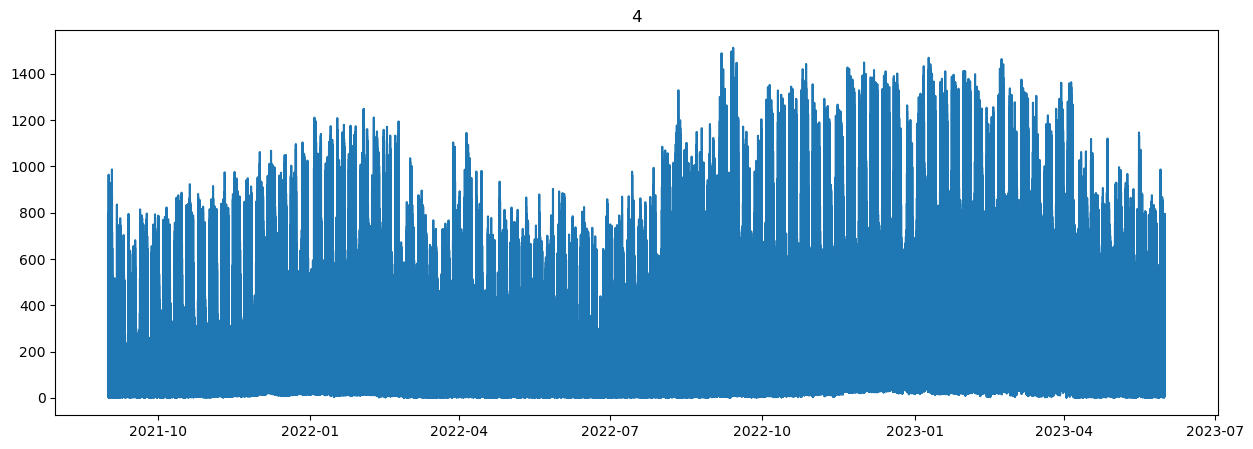

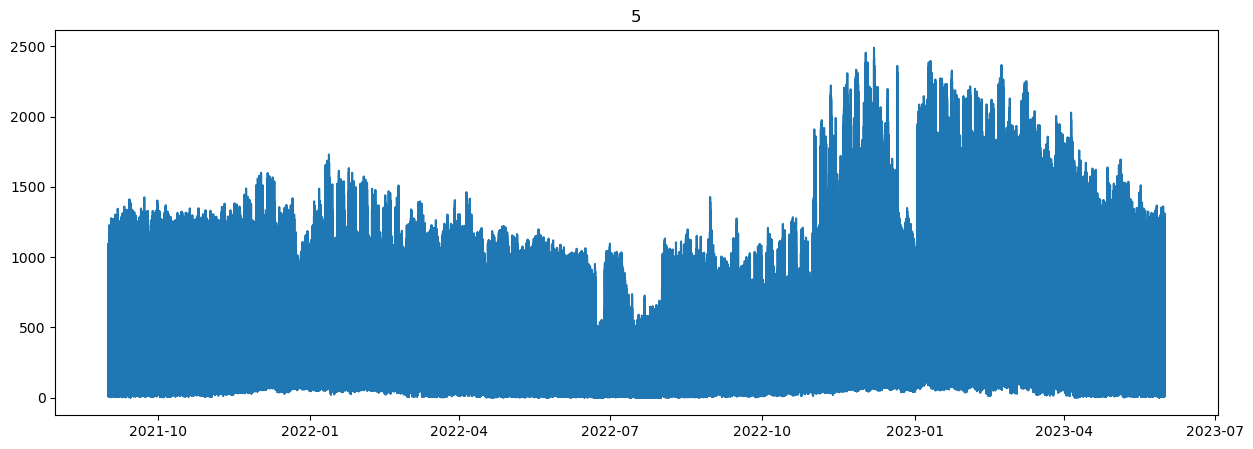

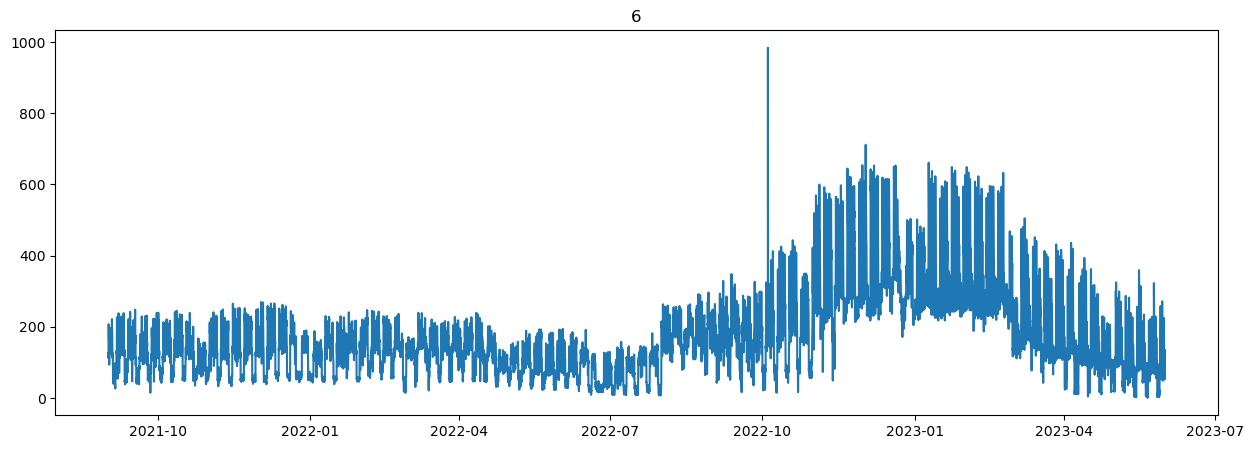

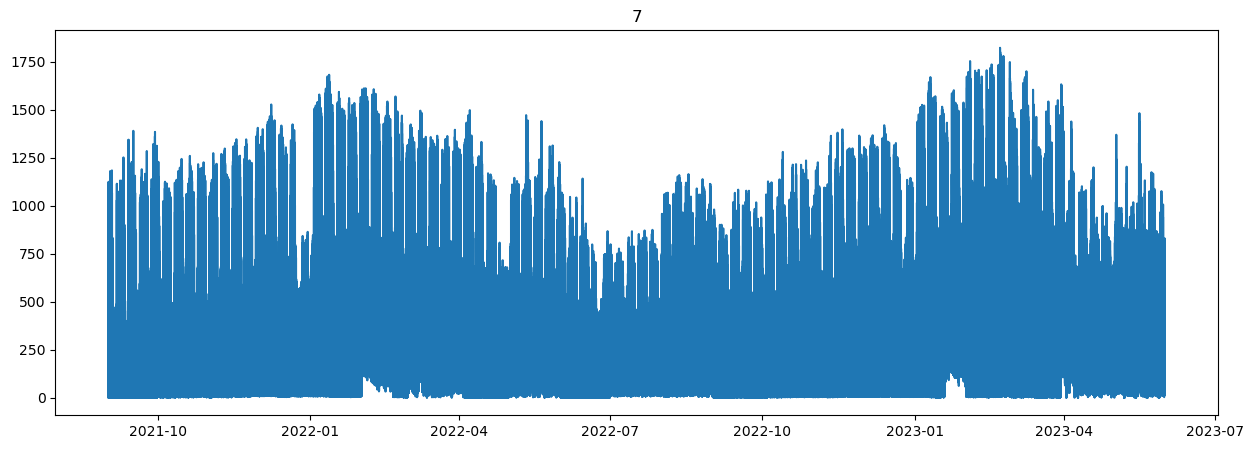

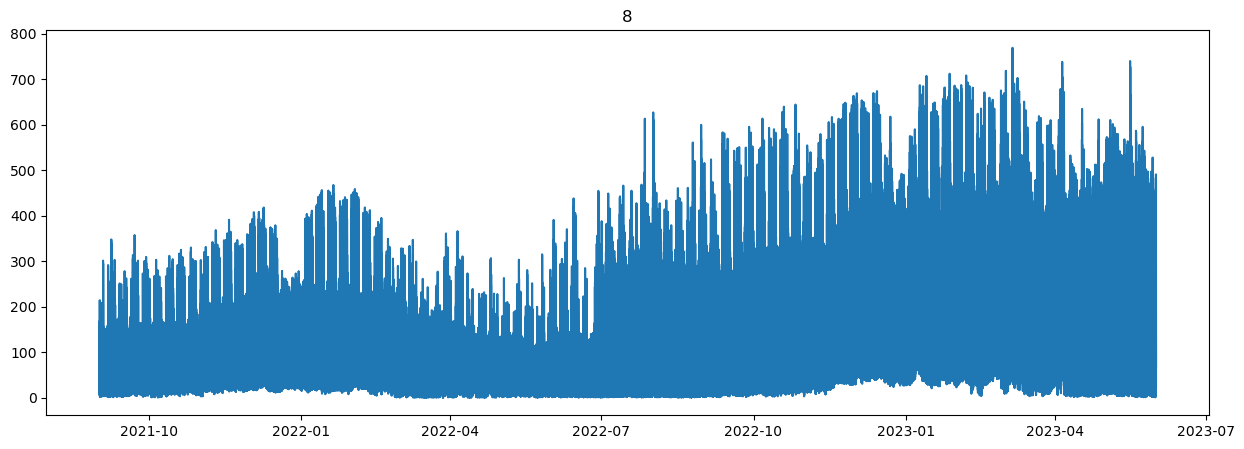

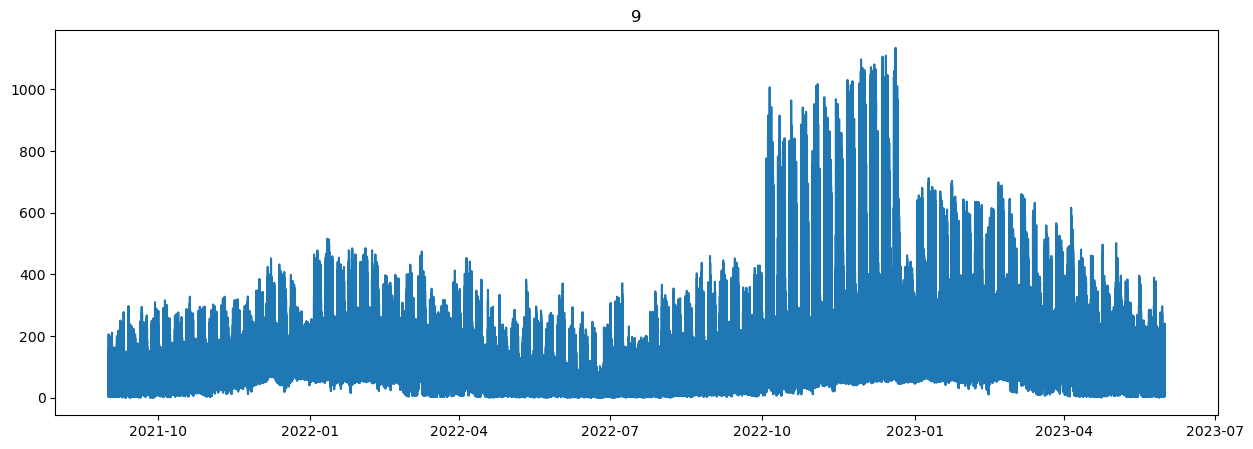

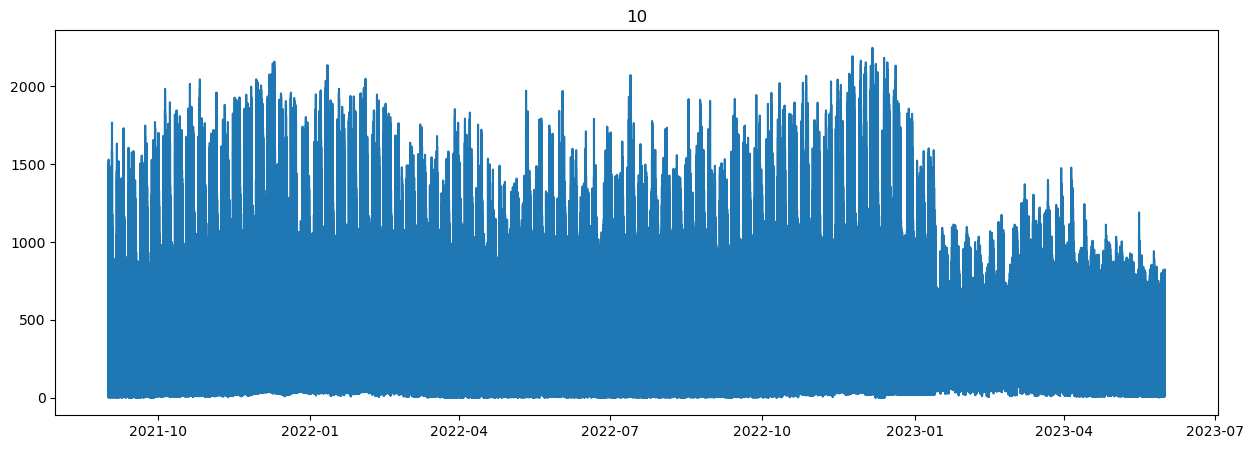

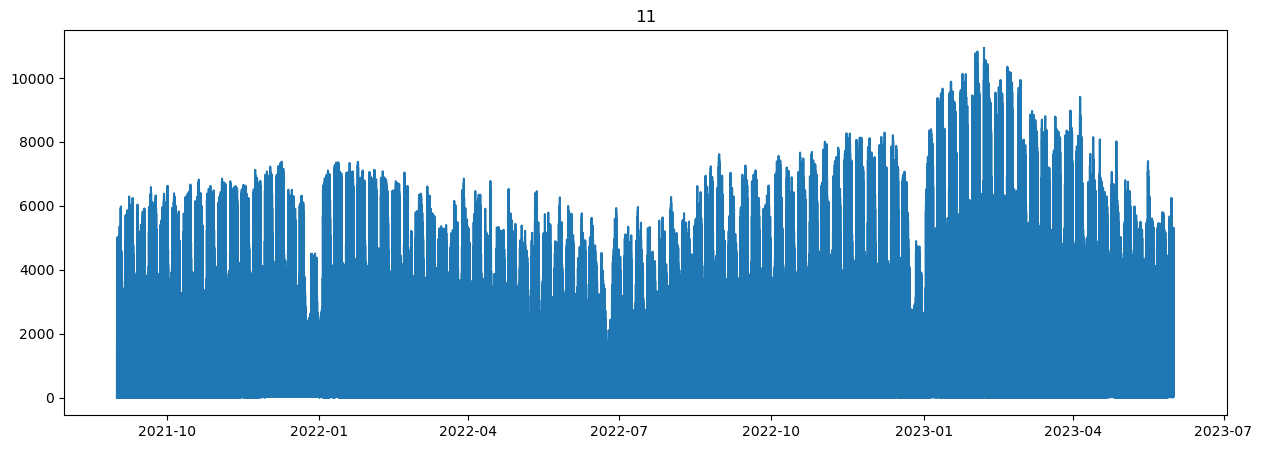

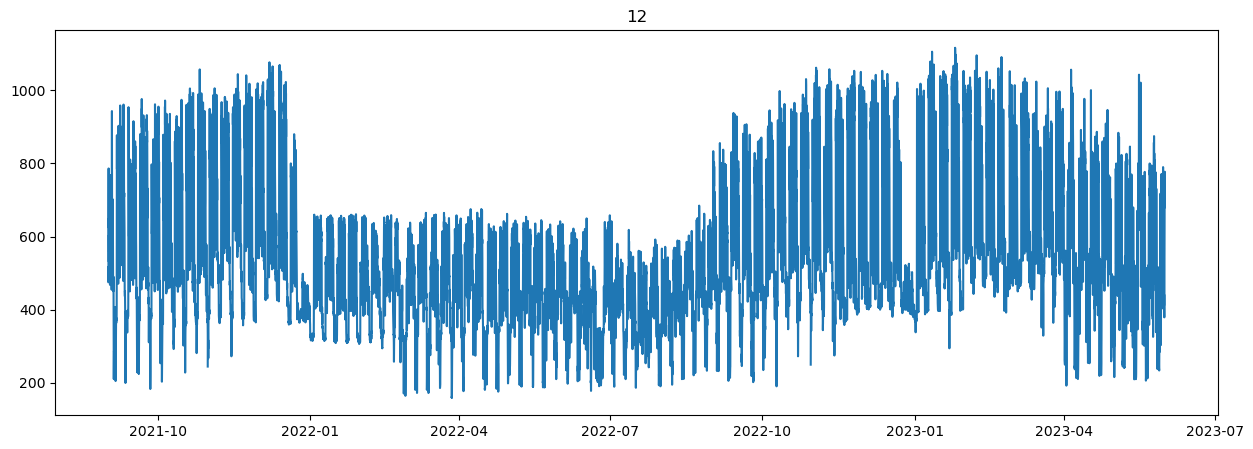

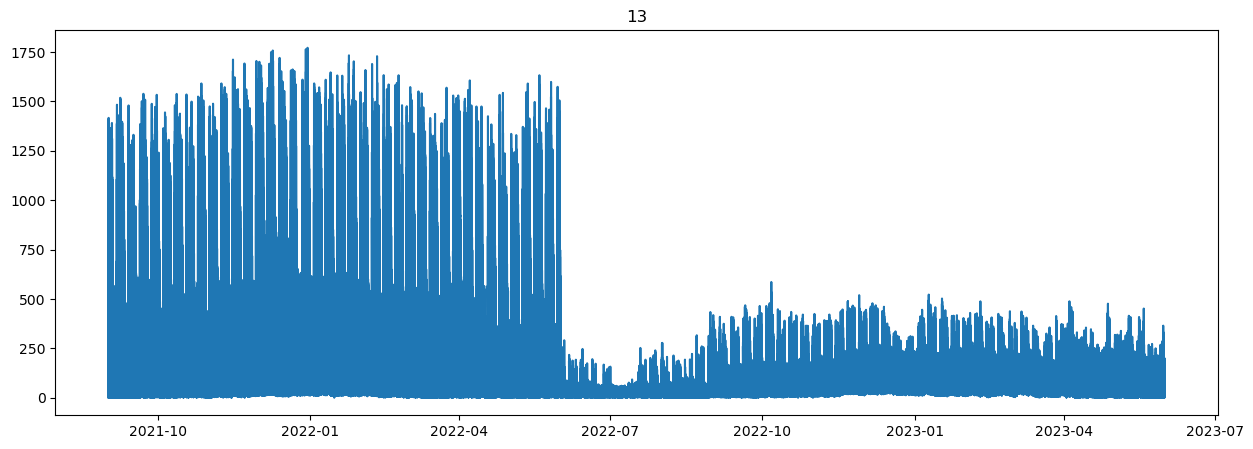

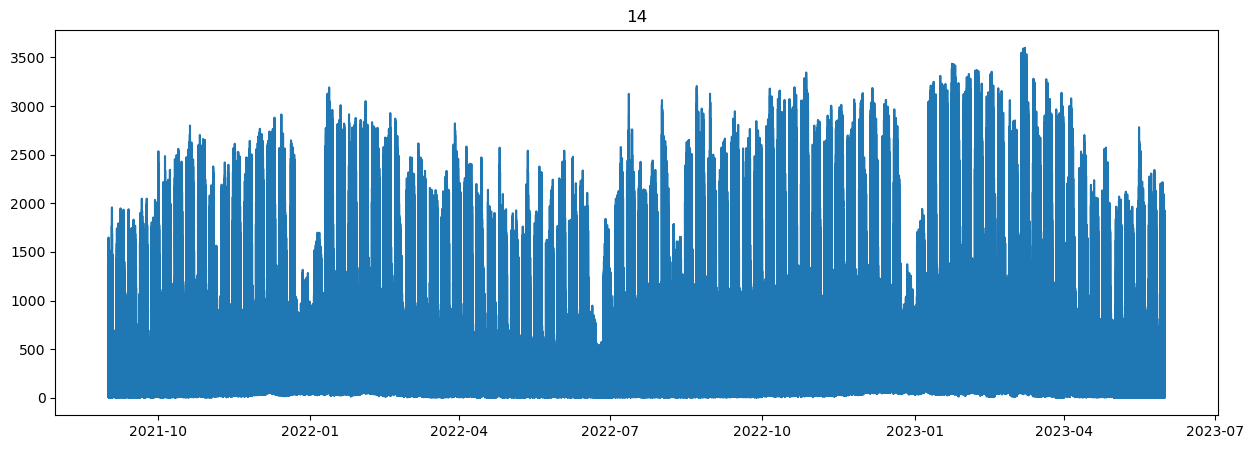

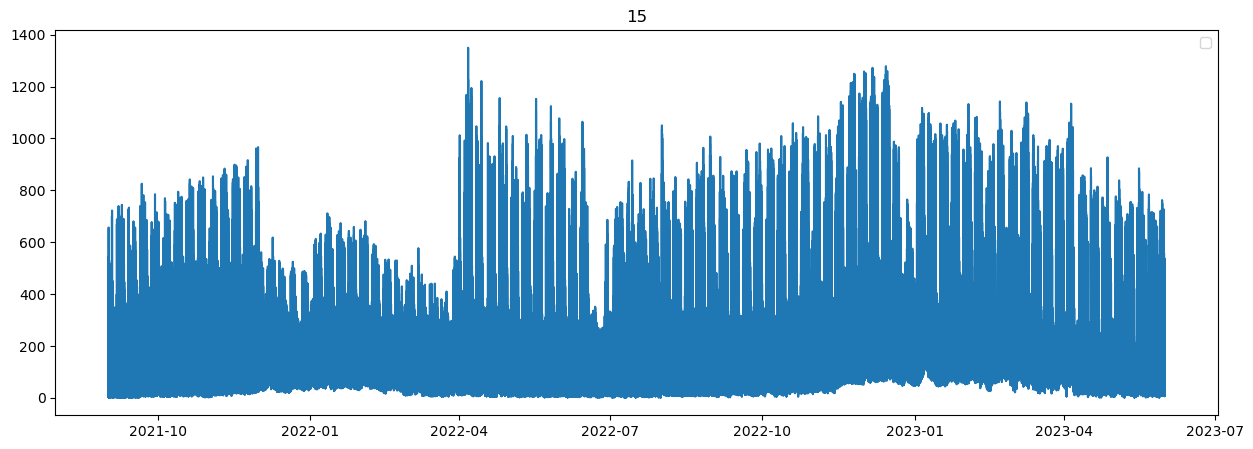

In [18]:
# county별로 살펴보기
df_consumption = df[df['is_consumption']==1]
plt.figure(figsize=(15,5))
for i in range(len(df['county'].unique())):
    plt.figure(figsize=(15,5))
    plt.plot(df_consumption[df_consumption['county']==i]['target'])
    plt.title(i)
plt.legend()

- 이상치
    - county 6에서 2022년 10월

In [19]:
# target값이 0인 행 출력 => null값으로 봐야하는 것인지 확인
df_consumption[df_consumption['target']==0]

county  is_business  product_type  target  \
datetime                                                         
2021-09-04 11:00:00       0            1             0     0.0   
2021-09-04 12:00:00       0            1             0     0.0   
2021-09-05 12:00:00       0            1             0     0.0   
2021-09-05 14:00:00       0            1             0     0.0   
2021-09-05 15:00:00       0            1             0     0.0   
...                     ...          ...           ...     ...   
2023-05-28 12:00:00       0            1             2     0.0   
2023-05-28 12:00:00       7            1             0     0.0   
2023-05-28 13:00:00       7            1             0     0.0   
2023-05-28 14:00:00       7            1             0     0.0   
2023-05-31 10:00:00       0            1             2     0.0   

                     is_consumption            datetime  data_block_id  \
datetime                                                                 
2021-09-04 11:00:00               1 2021-09-04 11:00:00              3   
2021-09-04 12:00:00               1 2021-09-04 12:00:00              3   
2021-09-05 12:00:00               1 2021-09-05 12:00:00              4   
2021-09-05 14:00:00               1 2021-09-05 14:00:00              4   
2021-09-05 15:00:00               1 2021-09-05 15:00:00              4   
...                             ...                 ...            ...   
2023-05-28 12:00:00               1 2023-05-28 12:00:00            634   
2023-05-28 12:00:00               1 2023-05-28 12:00:00            634   
2023-05-28 13:00:00               1 2023-05-28 13:00:00            634   
2023-05-28 14:00:00               1 2023-05-28 14:00:00            634   
2023-05-31 10:00:00               1 2023-05-31 10:00:00            637   

                      row_id  prediction_unit_id  
datetime                                          
2021-09-04 11:00:00    10133                   3  
2021-09-04 12:00:00    10255                   3  
2021-09-05 12:00:00    13183                   3  
2021-09-05 14:00:00    13427                   3  
2021-09-05 15:00:00    13549                   3  
...                      ...                 ...  
2023-05-28 12:00:00  2007443                  61  
2023-05-28 12:00:00  2007495                  28  
2023-05-28 13:00:00  2007625                  28  
2023-05-28 14:00:00  2007755                  28  
2023-05-31 10:00:00  2016543                  61  

[86 rows x 9 columns]

- 여름: 생산량 ▲, 소비량 ▼
- 겨울: 생산량 ▼, 소비량 ▲

원인 추측

- 날씨적 요인 -> 태양열으로 생산 가능한 에너지 감소, 난방 사용 증가

- 여름에 자체적으로 생산 가능한 에너지 증가 -> 공급되는 전기 사용은 감소?